# PA004 - HEALTH INSURANCE CROS-SELL

## 0 - IMPORTS AND FUNCTIONS

In [1]:
# Data Analysis and Data Manipulation Libraries
import pandas                  as pd
import numpy                   as np
import seaborn                 as sns
import matplotlib.pyplot       as plt
import plotly.express          as px
import matplotlib.pyplot       as plt
import matplotlib              as mpl
import inflection

# Machine Learning Models
import optuna
from xgboost                   import XGBClassifier
from sklearn.linear_model      import LogisticRegression
from sklearn.neighbors         import KNeighborsClassifier

from sklearn                   import model_selection as ms
from sklearn.model_selection   import  KFold, StratifiedKFold
from sklearn                   import pipeline

# Metrics and Performance
from sklearn.metrics           import precision_score, roc_auc_score, roc_curve,auc, recall_score
from sklearn.metrics           import precision_recall_curve

# Dysplay
from IPython.core.display    import HTML
from IPython.display         import Image

import warnings
warnings.filterwarnings( 'ignore' )

### 0.1 - HELPER FUNCTIONS

**Personalized functions** to help and improve the analysis.

In [2]:
def eda_analysis (data, features, categorical=False, numerical=False, boxplot=False):
    n_features = len(features)
    n_rows = n_features // 3 + (n_features % 3 > 0) 
        
    fig, axes = plt.subplots(n_rows, 3)  

    for i, feature in enumerate(features):
        row = i // 3  
        col = i % 3  
        ax = axes[row, col] if n_rows > 1 else axes[col]

        if numerical:
            if boxplot:
                sns.boxplot(data=data, x=feature, ax=ax )
                ax.set_title(feature, fontsize=15)  
                ax.set_xlabel('')
            else:
                count_n = data.groupby([feature])[[feature]].count().rename(columns={feature: 'count'}).reset_index()
                count_n['perc'] = count_n['count'] / count_n['count'].sum() * 100

                ax.barh( y=count_n[feature], width=count_n['perc'])

                if pd.api.types.is_numeric_dtype(count_n[feature]):
                    ax.invert_yaxis()

                for index, value in enumerate(count_n['perc']):
                    ax.text(value + 0.5, index, f'{value:.1f}%', va='center') # Adjust the text position based on the width of the bars
                
    
        if categorical:
            dt_count = data.groupby([feature])[[feature]].count().rename(columns={feature: 'count'}).reset_index()
            dt_count['perc'] = dt_count['count'] / dt_count['count'].sum() * 100
            
            ax.barh( y=dt_count[feature], width=dt_count['perc'])
            
            if pd.api.types.is_numeric_dtype(dt_count[feature]):
                ax.invert_yaxis()
            
            for index, value in enumerate(dt_count['perc']):
                ax.text(value + 0.5, index, f'{value:.1f}%', va='center') # Adjust the text position based on the width of the bars
                
            ax.set_yticks(ticks=range(dt_count[feature].nunique()), labels=dt_count[feature].tolist())
            ax.get_xaxis().set_visible(False)
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.spines['bottom'].set_visible(False)
            ax.spines['left'].set_visible(False)
            ax.grid(False)
            
            ax.set_title(feature, fontsize=15)   
            ax.set_xlabel('')  
                
    # Remove unused axes.
    if n_features < len(axes.flat):
        for j in range(n_features, len(axes.flat)):
            fig.delaxes(axes.flat[j])

    plt.tight_layout()

def ml_performance( model_name, precision_atK, recall_atK):
        
        return pd.DataFrame( {'Model Name': model_name,
                              'Precision_at_K': precision_atK,
                              'Recall_at_K': recall_atK}, index=[0] )

def precision_at_k_cv(y_true, proba_predictions, k):
    # Sort the estimated probabilities in descending order.
    sorted_indices = np.argsort(proba_predictions[:, 1])[::-1]
    top_k_indices = sorted_indices[:k]
    
    # Convert the probabilities into binary labels using the top k.
    binary_predictions = np.zeros_like(y_true)
    binary_predictions[top_k_indices] = 1
    
    # Calculate precision at k.
    precision_at_k = precision_score(y_true, binary_predictions)
    
    return precision_at_k

def recall_at_k_cv(y_true, proba_predictions, k):
    # Sort the estimated probabilities in descending order.
    sorted_indices = np.argsort(proba_predictions[:, 1])[::-1]
    top_k_indices = sorted_indices[:k]
    
    # Convert the probabilities into binary labels using the top k.
    binary_predictions = np.zeros_like(y_true)
    binary_predictions[top_k_indices] = 1
    
    # Calculate recall at k
    recall_at_k = recall_score(y_true, binary_predictions)
    
    return recall_at_k

def cross_validation(kfold, modelName, model, X, y, at_k):
    
    # Number of folds
    fold=ms.StratifiedKFold(n_splits = kfold, shuffle=True, random_state=42)
    
    # Performance variables
    precision_list = []
    recall_list = []
    cv_performance = {}
    
    for train_cv,val_cv in fold.split(X, y):
        
        # Separating train and validation dataset for each kfold
        # training data
        x_train_fold = X.iloc[train_cv]
        x_train_fold = x_train_fold
        
        y_train_fold = y.iloc[train_cv]
        y_train_fold = y_train_fold
        
        # validation data
        x_val_fold = X.iloc[val_cv]
        x_val_fold = x_val_fold
        
        y_val_fold = y.iloc[val_cv]
        y_val_fold = y_val_fold
        
        # fitting the model
        model_fitted = model.fit(x_train_fold, y_train_fold)
        
        # getting the prediction probability
        x_val_fold['response'] = y_val_fold
        val_scored = prediction_score(model_fitted, x_val_fold)
        
        # Getting precision and recall at k
        precision = val_scored.loc[at_k, 'precision_at_k']
        recall = val_scored.loc[at_k, 'recall_at_k']
        
        precision_list.append(precision)
        recall_list.append(recall)
        
    # calculating the mean and std performance of all kfolds
    precision_cv = np.round(np.mean(precision_list),4).astype(float)
    std_precision_cv = '+/-' + np.round(np.std(precision_list),4).astype(str)
    recall_cv = np.round(np.mean(recall_list),4).astype(float)
    std_recall_cv = ' +/- ' + np.round(np.std(recall_list),4).astype(str)
        
    cv_performance[modelName] = [precision_cv, std_precision_cv, recall_cv, std_recall_cv]
    model_performance_cv = pd.DataFrame(cv_performance, index=['precision_at_k', 'std_precision', 'recall_at_k', 'std_recall'])

    return model_performance_cv

def prediction_score(model, data):
    # Separating train and validation dataset for each kfold
    x_train = data.drop(columns=['response'])
    y_train = data['response']
    
    # prediction probability (score)
    yhat_proba = model.predict_proba(x_train)[:, 1].tolist()
    
    # merging score to dataset
    data_scored = data.copy()
    data_scored['score'] = yhat_proba
    
    # sort
    data_scored = data_scored.sort_values('score', ascending=False)
    
    # precision and recall
    data_scored = data_scored.reset_index(drop=True)
    data_scored['n_samples'] = data_scored.index + 1
    data_scored['precision_at_k'] = data_scored['response'].cumsum() / data_scored['n_samples']
    data_scored['recall_at_k'] = data_scored['response'].cumsum() / data_scored['response'].sum()
    
    return data_scored

def jupyter_settings():
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
   
    sns.set()
    
jupyter_settings()

### Visualization Settings
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'

mpl.style.use( 'ggplot' )
mpl.rcParams['axes.facecolor']      = 'white'
mpl.rcParams['axes.linewidth']      = 1
mpl.rcParams['xtick.color']         = 'black'
mpl.rcParams['ytick.color']         = 'black'
mpl.rcParams['grid.color']          = 'lightgray'
mpl.rcParams['figure.dpi']          = 120
mpl.rcParams['axes.grid']           = True
mpl.rcParams['font.size']           = 10
mpl.rcParams['figure.figsize']      = [18, 7]
mpl.rcParams['font.size']           = 15

# Palette Setting
color_palette = ['#82B1FF', '#FF9100', '#40C4FF', '#A7FFEB', '#CCFF90', '#616161']

# Setting as the palette
sns.set_palette(sns.color_palette(color_palette))

# Display
sns.color_palette(color_palette)

[(0.5098039215686274, 0.6941176470588235, 1.0),
 (1.0, 0.5686274509803921, 0.0),
 (0.25098039215686274, 0.7686274509803922, 1.0),
 (0.6549019607843137, 1.0, 0.9215686274509803),
 (0.8, 1.0, 0.5647058823529412),
 (0.3803921568627451, 0.3803921568627451, 0.3803921568627451)]

## 1 - LOADING THE DATA

- The dataset was collected from this kaggle competition **https://www.kaggle.com/datasets/anmolkumar/health-insurance-cross-sell-prediction**

In [3]:
# Train Datas - Windows
df_raw = pd.read_csv('../data/raw/data.csv')

| **Variable**         | **Definition**                                                                                                              |
| -------------------- | --------------------------------------------------------------------------------------------------------------------------- |
| id                   | Unique ID for the customer                                                                                                  |
| Gender               | Gender of the customer                                                                                                      |
| Age                  | Age of the customer                                                                                                         |
| Driving_License      | 0 : Customer does not have DL, 1 : Customer already has DL                                                                  |
| Region_Code          | Unique code for the region of the customer                                                                                  |
| Previously_Insured   | 1 : Customer already has Vehicle Insurance, 0 : Customer doesn't have Vehicle Insurance                                     |
| Vehicle_Age          | Age of the Vehicle                                                                                                          |
| Vehicle_Damage       | 1 : Customer got his/her vehicle damaged in the past. 0 : Customer didn't get his/her vehicle damaged in the past.          |
| Annual_Premium       | The amount customer needs to pay as premium in the year                                                                     |
| Policy_Sales_Channel | Anonymized Code for the channel of outreaching to the customer ie. Different Agents, Over Mail, Over Phone, In Person, etc. |
| Vintage              | Number of Days, Customer has been associated with the company                                                               |
| Response             | 1 : Customer is interested, 0 : Customer is not interested                                                                  |

### 1.1 - DATA DIMENSIONS

In [4]:
df1 = df_raw.copy()

In [5]:
df1.head()

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,previously_insured,annual_premium,vintage,response
0,7,Male,23,11,152,1,< 1 Year,Yes,0,23367,249,0
1,13,Female,41,15,14,1,1-2 Year,No,1,31409,221,0
2,18,Female,25,35,152,1,< 1 Year,No,1,46622,299,0
3,31,Female,26,8,160,1,< 1 Year,No,0,2630,136,0
4,39,Male,45,8,124,1,1-2 Year,Yes,0,42297,264,0


In [6]:
# Data Dimensions
print( 'The dataset contains {}'.format( df1.shape[0] ),'rows.' )
print( 'The dataset contains {}'.format( df1.shape[1] ),'columns.' )

The dataset contains 381109 rows.
The dataset contains 12 columns.


In [7]:
# Data Types
df1.dtypes

id                       int64
gender                  object
age                      int64
region_code              int64
policy_sales_channel     int64
driving_license          int64
vehicle_age             object
vehicle_damage          object
previously_insured       int64
annual_premium           int64
vintage                  int64
response                 int64
dtype: object

**Some of the data are with the wrong data type:**
   - **id**: is an identification for each customer, so each line has an unique value and we cannot use at math operations. I will change the data type from integer to string;
   - **region_code**: is an identification of the region where each customer is from and we cannot use at math operations. I will change the data type from integer to string;
   - **policy_sales_channel**: is an identification of the channel used to contact the customer and this cannot be used for math operations. I will change the data type from integer to string;  


In [8]:
# # Changing Data Types
# df1['id'] = df1['id'].astype( str ) # ID of each customer
# df1['region_code'] = df1['region_code'].astype( str ) # Code of region, we cannot do maths operations with these values
# df1['policy_sales_channel'] = df1['policy_sales_channel'].astype( str ) # Code of sales channel, we cannot do maths operations with these values

In [9]:
# Data Types
df1.dtypes

id                       int64
gender                  object
age                      int64
region_code              int64
policy_sales_channel     int64
driving_license          int64
vehicle_age             object
vehicle_damage          object
previously_insured       int64
annual_premium           int64
vintage                  int64
response                 int64
dtype: object

In [10]:
# Check NAN Values
df1.isna().sum()

id                      0
gender                  0
age                     0
region_code             0
policy_sales_channel    0
driving_license         0
vehicle_age             0
vehicle_damage          0
previously_insured      0
annual_premium          0
vintage                 0
response                0
dtype: int64

There are no missing values on this dataset.

In [11]:
# Duplicated Values
df1.duplicated().sum()

0

There are no duplicated values on this dataset.

### 1.2 - DATA DESCRIPTIVE

To describe the datas, I will create two new dataframes:
- num_attributes: contains the features that could be used on math operations, such as: integer and float;
- cat_attributes: contains categorical features;

In [12]:
# Select columns where the content is different 0 or 1.
# numerical features
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
#num_attributes = df1[['id','age','region_code','policy_sales_channel','annual_premium','vintage']]

# categorical features
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64'])
#cat_attributes = df1[['gender','vehicle_age']]

#### 1.2.1 - NUMERICAL VARIABLES

In [13]:
# Central Tendency - mean, median
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( min ) ).T
d3 = pd.DataFrame( num_attributes.apply( max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

# Concatenar
m = pd.concat( [ d2, d3, d4, ct1, ct2, d1, d5, d6 ] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,id,1.0,381109.0,381108.0,190555.000000,190555.0,110016.691870,-8.071174e-18,-1.200000
1,age,20.0,85.0,65.0,38.822584,36.0,15.511591,6.725390e-01,-0.565655
2,region_code,0.0,52.0,52.0,26.388807,28.0,13.229871,-1.152664e-01,-0.867857
3,policy_sales_channel,1.0,163.0,162.0,112.034295,133.0,54.203924,-9.000081e-01,-0.970810
4,driving_license,0.0,1.0,1.0,0.997869,1.0,0.046109,-2.159518e+01,464.354302
5,previously_insured,0.0,1.0,1.0,0.458210,0.0,0.498251,1.677471e-01,-1.971871
6,annual_premium,2630.0,540165.0,537535.0,30564.389581,31669.0,17213.132474,1.766087e+00,34.004569
7,vintage,10.0,299.0,289.0,154.347397,154.0,83.671194,3.029517e-03,-1.200688
8,response,0.0,1.0,1.0,0.122563,0.0,0.327935,2.301906e+00,3.298788


Insights:

- **age**: Looking into the min and max values, it is possible to identify that the customers vary from 20 years old to 85 years old, where most part of them are younger than 40 years old, however the data is scattered between this interval.
- **anual_premium**: Looking into the min and max, the values have a high variation and more information about the business is necessary to understand if these values are consistent. The avg value is far from the max value recorded and also the value is scattered, it causes a high standard deviation. It would be good to get more information about the business to have a better understanding about the value.
- **vintage**: Analysing the min and max it is possible to identify that the customers are within the company from 10 days to 299 days. Around half oof them are within the company for less than 6 months however, the data is spread into this interval.

### 1.3 - DATASET SPLIT

In [14]:
# Checking if the data is imbalanced
df1['response'].value_counts(normalize=True)

response
0    0.877437
1    0.122563
Name: proportion, dtype: float64

- I will split the data into train, validation and test datasets.
- I will perform EDA focusing on the training set in order to avoid data leakage, get a realistic representation and evaluate the model correctly with new unseen data.
- I will specify stratify=y so that the train_test_split function ensures that the splitting process maintains the same percentage of each target class in both the training and testing sets. This is useful when dealing with imbalanced datasets.

In [15]:
# Split dataset into train, test and validation datasets
X = df_raw.drop( ['response'], axis=1 )
y = df_raw['response'].copy()
x_train, x_valid, y_train, y_valid = ms.train_test_split( X, y, test_size=0.20, stratify=y, random_state=42 )
x_train, x_test, y_train, y_test   = ms.train_test_split( x_train, y_train, test_size=0.25, stratify=y_train, random_state=42 )

print(f" x_train: {x_train.shape}\n y_train: {y_train.shape}\n x_valid: {x_valid.shape}\n y_valid: {y_valid.shape}\n x_test: {x_test.shape}\n y_test: {y_test.shape}\n")

 x_train: (228665, 11)
 y_train: (228665,)
 x_valid: (76222, 11)
 y_valid: (76222,)
 x_test: (76222, 11)
 y_test: (76222,)



In [16]:
print(y_train.value_counts(normalize=True))
print(y_valid.value_counts(normalize=True))
print(y_test.value_counts(normalize=True))

response
0    0.877436
1    0.122564
Name: proportion, dtype: float64
response
0    0.877437
1    0.122563
Name: proportion, dtype: float64
response
0    0.877437
1    0.122563
Name: proportion, dtype: float64


## 2 - FEATURE ENGINEERING

From this step, all process will be applied to the training dataset only. Afterwards an fuction will be created to apply everything to the others datasets.

In [17]:
df2 = pd.concat([x_train, y_train], axis=1)

In [18]:
# Modify vehicle_age to numerical values
df2['vehicle_age'] = df2['vehicle_age'].apply(lambda x: 1 if (x == '< 1 Year') else
                                                        2 if (x == '1-2 Year') else
                                                        3)

In [19]:
# Modify vehicle_damage to numerical values
df2['vehicle_damage'] = df2['vehicle_damage'].apply(lambda x: 1 if (x == 'Yes') else 0)

## 3 - DATA FILTERING

In [20]:
df3 = df2.copy()

## 4 - EXPLORATORY DATA ANALYSIS (EDA)

In [21]:
df4 = df3.copy()

In [22]:
cat_attributes.columns

Index(['gender', 'vehicle_age', 'vehicle_damage'], dtype='object')

### 4.1 - UNIVARIATE AND BIVARIATE ANALYSIS

#### 4.1.1 -  Num. Feature: region_code

**region_code** : is a unique code for the region of the customer.

Analysing the charts, some regions stands out than others in volum of customers, what could be used as an insight for future projects;

The top 5 region_code with high volum of customers are:
1. region code 28: 60000 customers approximately;
2. region code 8: 20000 customers approximately;
3. region code 46: 11000 customers approximately.
4. region code 41: 11000 customers approximately.
5. region code 15: 8000 customers approximately.

Almost 40% of the customers are from these 5 regions. This could be a valuable data for the company.

**There is too much data**, I will divide in two charts.

In [23]:
def hist_chart (data, feature_x, hue):
    fig, ax = plt.subplots(figsize=(7, 3)) # Define the figure and axis for the graph
    sns.histplot(data=data, x=feature_x, kde=True, hue=hue, ax=ax) # Creating the chart

    # Design
    ax.grid(axis='x', linestyle='None') # Hide only the vertical grid line
    ax.set_xlabel(None) # Hide x label
    ax.set_ylabel(None) # Hide y label
    
    # Setting the x labels
    uv = sorted(data[feature_x].unique())
    plt.xticks(ticks=uv)

    # Setting the legend
    chart_leg = ['Not Interested', 'Interested']
    ax.legend(labels=chart_leg, loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=2)
    
    # Setting title
    x_midpoint = (ax.get_xlim()[0] + ax.get_xlim()[1]) / 2 # Calculate the midpoint of the y-axis
    y_top = (ax.get_ylim()[0] + ax.get_ylim()[1]) * 1.2    # Add the title at the top of the axes

    ax.text(x_midpoint, y_top, s=feature_x, fontsize=10, color='#8C908F', weight='bold', ha='center', va='top')

    # Plot the chart
    plt.tight_layout()
    plt.show()

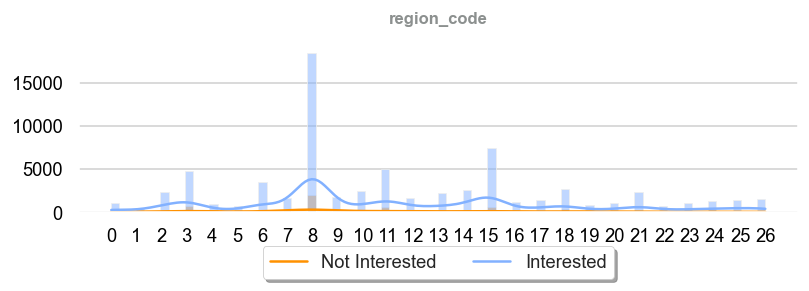

In [24]:
# Filtering the Data
df_rc26 = df4[df4['region_code'] <= 26]


# Ploting the Chart
hist_chart(df_rc26,'region_code','response')

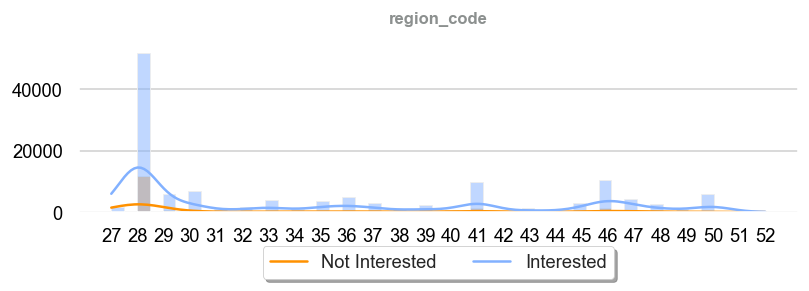

In [25]:
# Filtering the Data
df_rc52 = df4[df4['region_code'] > 26]

# Ploting the Chart
hist_chart(df_rc52,'region_code','response')

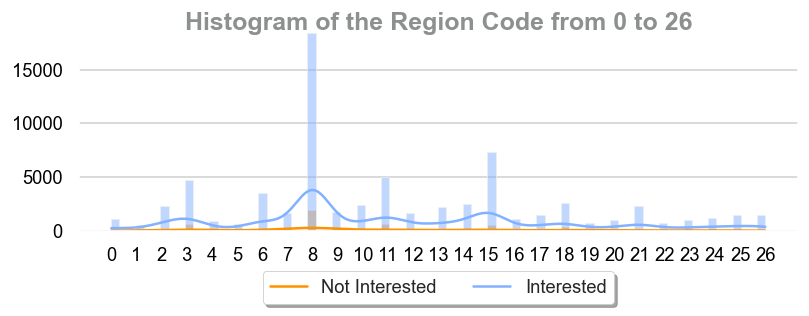

In [26]:
###### DATA FILTERING #####
df_rc26 = df4[df4['region_code'] <= 26]

##### CHART CREATION #####
fig, ax = plt.subplots(figsize=(7, 3)) # Define the figure and axis for the graph

sns.histplot(data=df_rc26, x='region_code', kde=True, hue='response', ax=ax) # creating the graph

##### SETTING THE AXIS X LABELS ( TO APPEAR AL NUMBERS) #####

# Obtaining the values for 'region_code'
unique_region_codes = sorted(df_rc26['region_code'].unique())

# Setting unique values as ticks do eixo x
plt.xticks(ticks=unique_region_codes)

##### HIDE ELEMENTS #####
# Hide only the vertical grid lines
ax.grid(axis='x', linestyle='None') # Hide only the vertical grid line
ax.set_xlabel(None) # Hide x label
ax.set_ylabel(None) # Hide y label

##### ADD A PERSONALIZED LEGEND #####

# Define explicit labels for the legend
legend_labels = ['Not Interested', 'Interested']

# Move the legend below the plot
ax.legend(labels=legend_labels, loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=2)

##### TITLE #####
# Calculate the midpoint of the x-axis
x_midpoint = (ax.get_xlim()[0] + ax.get_xlim()[1]) / 2 # Calculate the midpoint of the y-axis
y_top = (ax.get_ylim()[0] + ax.get_ylim()[1]) + 1000 # Add the title at the top of the axes

ax.text(x_midpoint, y_top, s='Histogram of the Region Code from 0 to 26', fontsize=15, color='#8C908F', weight='bold', ha='center', va='top')

# PLOT
plt.tight_layout()
plt.show()

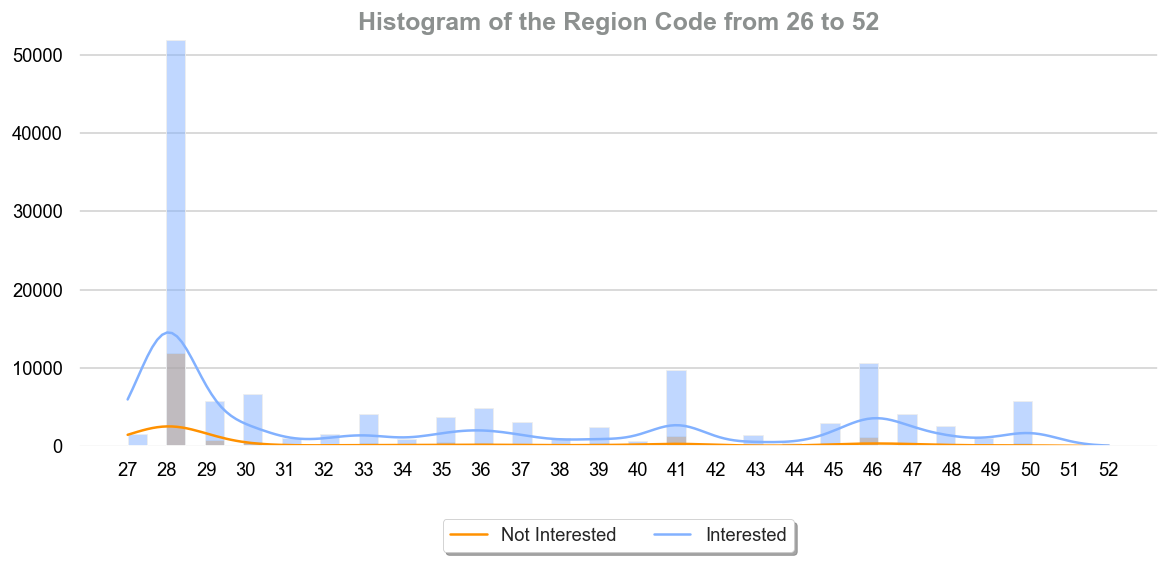

In [27]:
###### DATA FILTERING #####
df_rc52 = df4[df4['region_code'] > 26]

##### CHART CREATION #####
fig, ax = plt.subplots(figsize=(10, 5)) # Define the figure and axis for the graph

sns.histplot(data=df_rc52, x='region_code', kde=True, hue='response', ax=ax) # creating the graph

##### SETTING THE AXIS X LABELS ( TO APPEAR AL NUMBERS) #####

# Obtaining the values for 'region_code'
unique_region_codes = sorted(df_rc52['region_code'].unique())

# Setting unique values as ticks do eixo x
plt.xticks(ticks=unique_region_codes)

##### HIDE ELEMENTS #####
# Hide only the vertical grid lines
ax.grid(axis='x', linestyle='None') # Hide only the vertical grid line
ax.set_xlabel(None) # Hide x label
ax.set_ylabel(None) # Hide y label

##### ADD A PERSONALIZED LEGEND #####

# Define explicit labels for the legend
legend_labels = ['Not Interested', 'Interested']

# Move the legend below the plot
ax.legend(labels=legend_labels, loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=2)

##### TITLE #####
# Calculate the midpoint of the x-axis
x_midpoint = (ax.get_xlim()[0] + ax.get_xlim()[1]) / 2 # Calculate the midpoint of the y-axis
y_top = (ax.get_ylim()[0] + ax.get_ylim()[1]) + 1000   # Add the title at the top of the axes

ax.text(x_midpoint, y_top, s='Histogram of the Region Code from 26 to 52', fontsize=15, color='#8C908F', weight='bold', ha='center', va='top')

# PLOT
plt.tight_layout()
plt.show()

#### 4.1.2 - Num. Feature: policy_sales_channel

**policy sales channel**: Anonymized Code for the channel of outreaching to the customer ie. Different Agents, Over Mail, Over Phone, In Person, etc.

Taking a look into the charts for this feature, it is possible to identify that some channel stand out from the others. The top 5 channel with a high volum of customers are:

1. policy sales channel 152: 80000 customers approximatelly.
2. policy sales channel 26: 50000 customers approximatelly.
3. policy sales channel 124: 44000 customers approximatelly.
4. policy sales channel 160: 13000 customers approximatelly.
5. policy sales channel 156: 6500 customers approximatelly.


More than 70% of the customers are from these 5 channel, and approximately 75% of the interested customers are within these channel. This is also a valuable information for the company, where they can analyse if it is necessary to have a range of more than 160 ways to contact customers when 5 of them hold the high volum of customers.

**There are also too much data**, my approach will be same as above, I will divide the content in eight graphs.

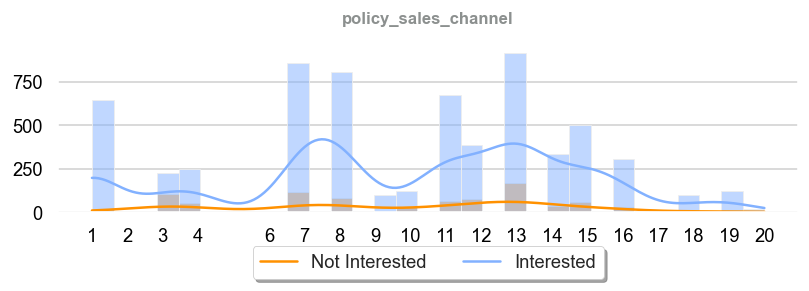

In [28]:
# Filtering the Data
df_psc20 = df4[df4['policy_sales_channel'] <= 20]

# Ploting the Chart
hist_chart(df_psc20,'policy_sales_channel','response')

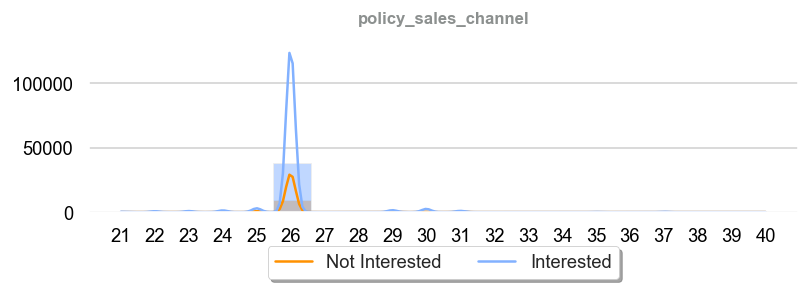

In [29]:
# Filtering the Data
df_psc40 = df4[ (df4['policy_sales_channel'] > 20) & (df4['policy_sales_channel'] <= 40)]

# Ploting the Chart
hist_chart(df_psc40,'policy_sales_channel','response')

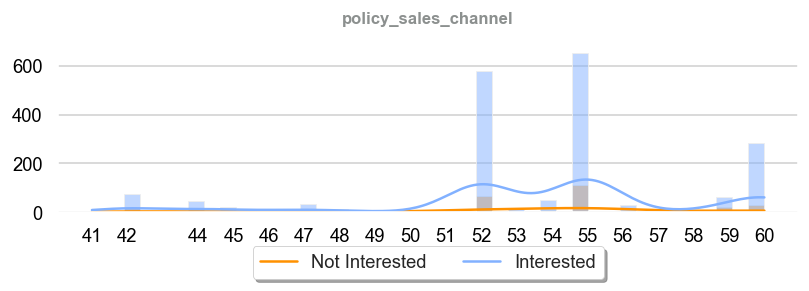

In [30]:
# Filtering the Data
df_psc60 = df4[ (df4['policy_sales_channel'] > 40) & (df4['policy_sales_channel'] <= 60)]

# Ploting the Chart
hist_chart(df_psc60,'policy_sales_channel','response')

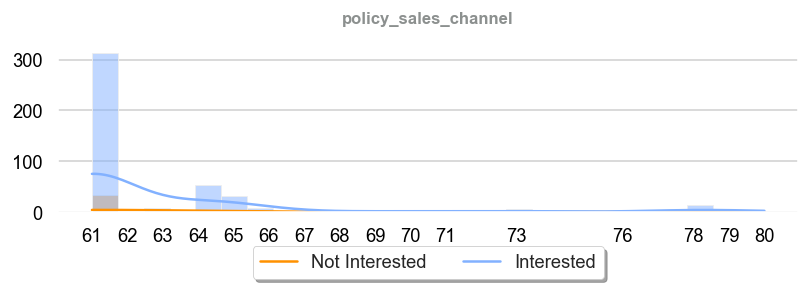

In [31]:
# Filtering the Data
df_psc80 = df4[ (df4['policy_sales_channel'] > 60) & (df4['policy_sales_channel'] <= 80)]

# Ploting the Chart
hist_chart(df_psc80,'policy_sales_channel','response')

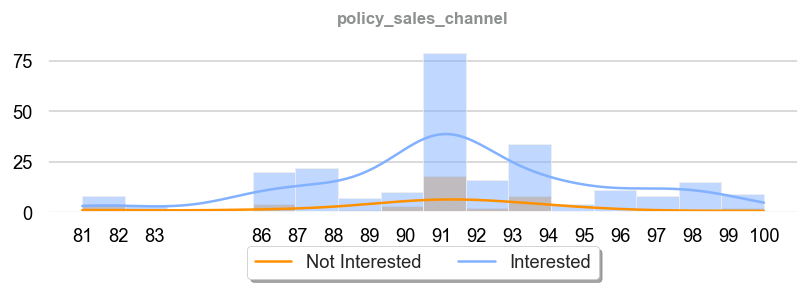

In [32]:
# Filtering the Data
df_psc100 = df4[ (df4['policy_sales_channel'] > 80) & (df4['policy_sales_channel'] <= 100)]


# Ploting the Chart
hist_chart(df_psc100,'policy_sales_channel','response')

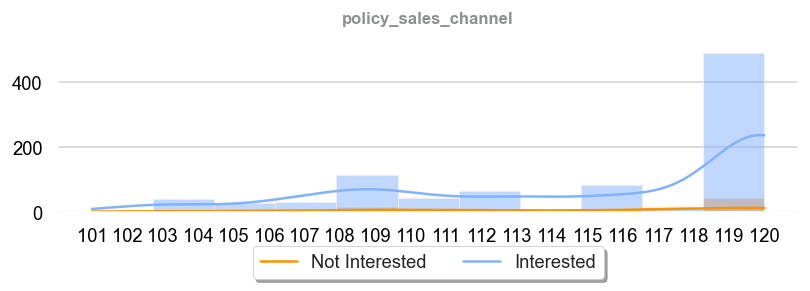

In [33]:
# Filtering the Data
df_psc120 = df4[ (df4['policy_sales_channel'] > 100) & (df4['policy_sales_channel'] <= 120)]

# Ploting the Chart
hist_chart(df_psc120,'policy_sales_channel','response')

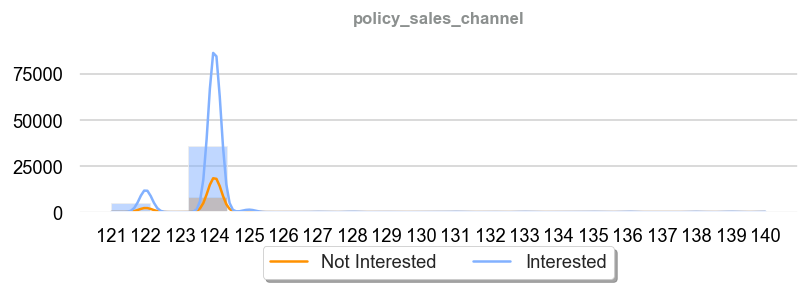

In [34]:
# Filtering the Data
df_psc140 = df4[ (df4['policy_sales_channel'] > 120) & (df4['policy_sales_channel'] <= 140)]

# Ploting the Chart
hist_chart(df_psc140,'policy_sales_channel','response')

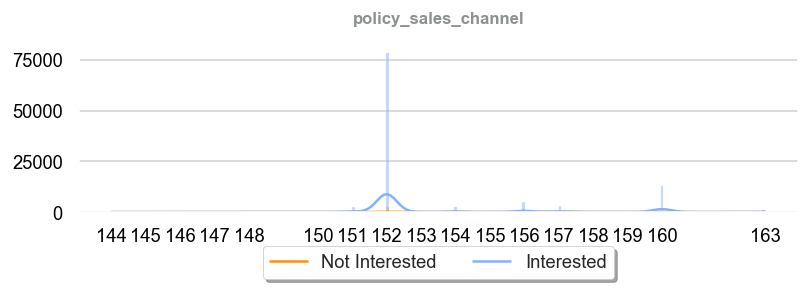

In [35]:
# Filtering the Data
df_psc160 = df4[ (df4['policy_sales_channel'] > 140) & (df4['policy_sales_channel'] <= 200)]

# Ploting the Chart
hist_chart(df_psc160,'policy_sales_channel','response')

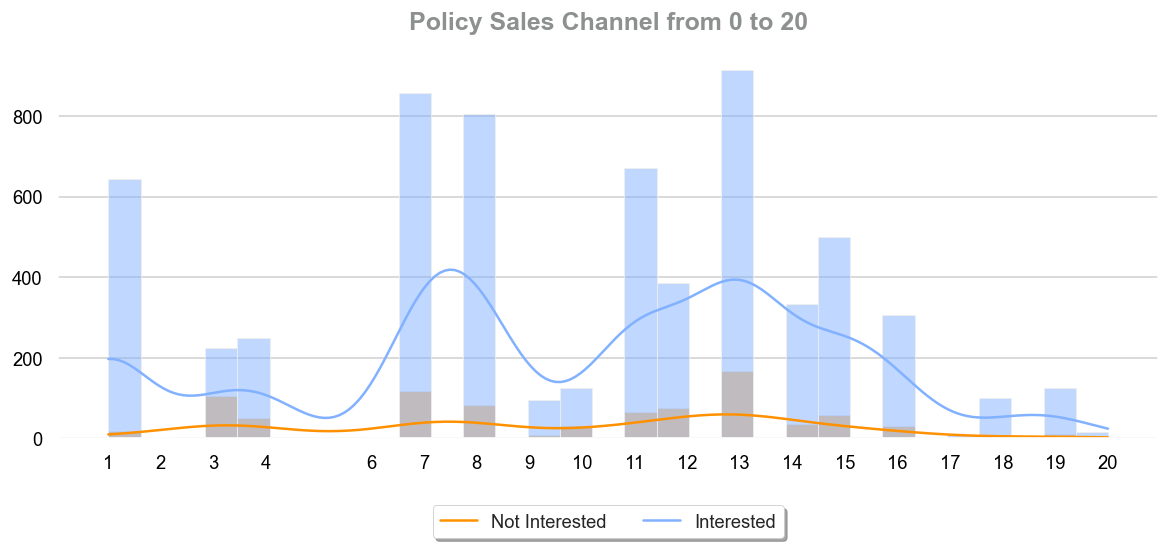

In [36]:
###### DATA FILTERING #####
df_psc20 = df4[df4['policy_sales_channel'] <= 20]

##### CHART CREATION #####
fig, ax = plt.subplots(figsize=(10, 5)) # Define the figure and axis for the graph

sns.histplot(data=df_psc20, x='policy_sales_channel', kde=True, hue='response', ax=ax) # creating the graph

##### SETTING THE AXIS X LABELS ( TO APPEAR AL NUMBERS) #####

# Obtaining the values for 'region_code'
unique_psc = sorted(df_psc20['policy_sales_channel'].unique())

# Setting unique values as ticks do eixo x
plt.xticks(ticks=unique_psc)

##### HIDE ELEMENTS #####
# Hide only the vertical grid lines
ax.grid(axis='x', linestyle='None') # Hide only the vertical grid line
ax.set_xlabel(None) # Hide x label
ax.set_ylabel(None) # Hide y label

##### ADD A PERSONALIZED LEGEND #####

# Define explicit labels for the legend
legend_labels = ['Not Interested', 'Interested']

# Move the legend below the plot
ax.legend(labels=legend_labels, loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=2)

##### TITLE #####
# Calculate the midpoint of the x-axis
x_midpoint = (ax.get_xlim()[0] + ax.get_xlim()[1]) / 2 # Calculate the midpoint of the y-axis
y_top = (ax.get_ylim()[0] + ax.get_ylim()[1]) + 100 # Add the title at the top of the axes

ax.text(x_midpoint, y_top, s='Policy Sales Channel from 0 to 20', fontsize=15, color='#8C908F', weight='bold', ha='center', va='top')

# PLOT
plt.tight_layout()
plt.show()

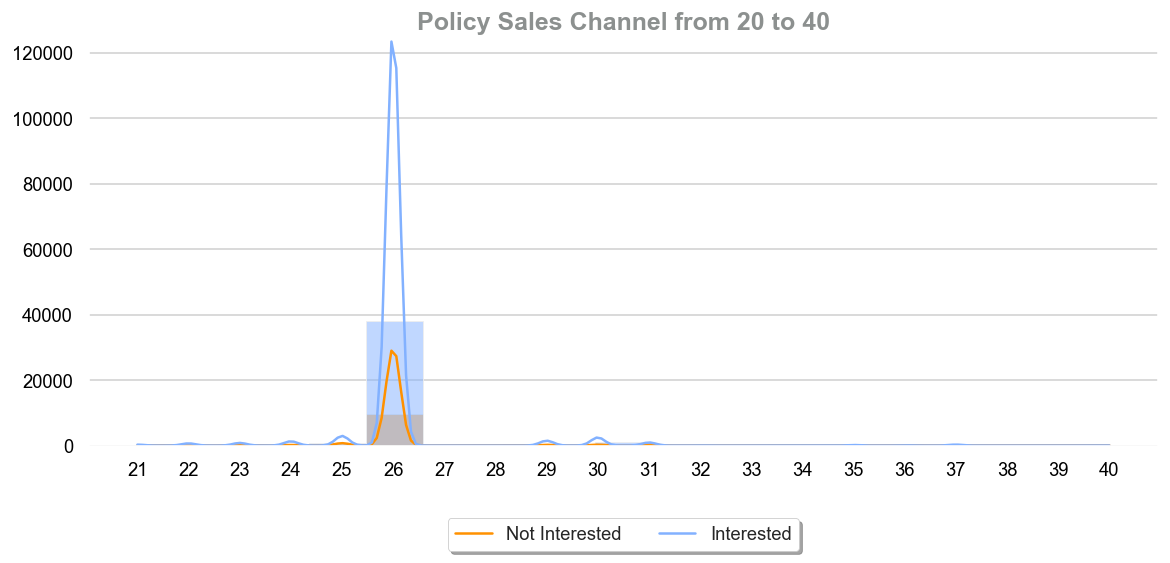

In [37]:
###### DATA FILTERING #####
df_psc40 = df4[ (df4['policy_sales_channel'] > 20) & (df4['policy_sales_channel'] <= 40)]

##### CHART CREATION #####
fig, ax = plt.subplots(figsize=(10, 5)) # Define the figure and axis for the graph

sns.histplot(data=df_psc40, x='policy_sales_channel', kde=True, hue='response', ax=ax) # creating the graph

##### SETTING THE AXIS X LABELS ( TO APPEAR AL NUMBERS) #####

# Obtaining the values for 'region_code'
unique_psc = sorted(df_psc40['policy_sales_channel'].unique())

# Setting unique values as ticks do eixo x
plt.xticks(ticks=unique_psc)

##### HIDE ELEMENTS #####
# Hide only the vertical grid lines
ax.grid(axis='x', linestyle='None') # Hide only the vertical grid line
ax.set_xlabel(None) # Hide x label
ax.set_ylabel(None) # Hide y label

##### ADD A PERSONALIZED LEGEND #####

# Define explicit labels for the legend
legend_labels = ['Not Interested', 'Interested']

# Move the legend below the plot
ax.legend(labels=legend_labels, loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=2)

##### TITLE #####
# Calculate the midpoint of the x-axis
x_midpoint = (ax.get_xlim()[0] + ax.get_xlim()[1]) / 2 # Calculate the midpoint of the y-axis
y_top = (ax.get_ylim()[0] + ax.get_ylim()[1]) + 3000   # Add the title at the top of the axes

ax.text(x_midpoint, y_top, s='Policy Sales Channel from 20 to 40', fontsize=15, color='#8C908F', weight='bold', ha='center', va='top')

# PLOT
plt.tight_layout()
plt.show()

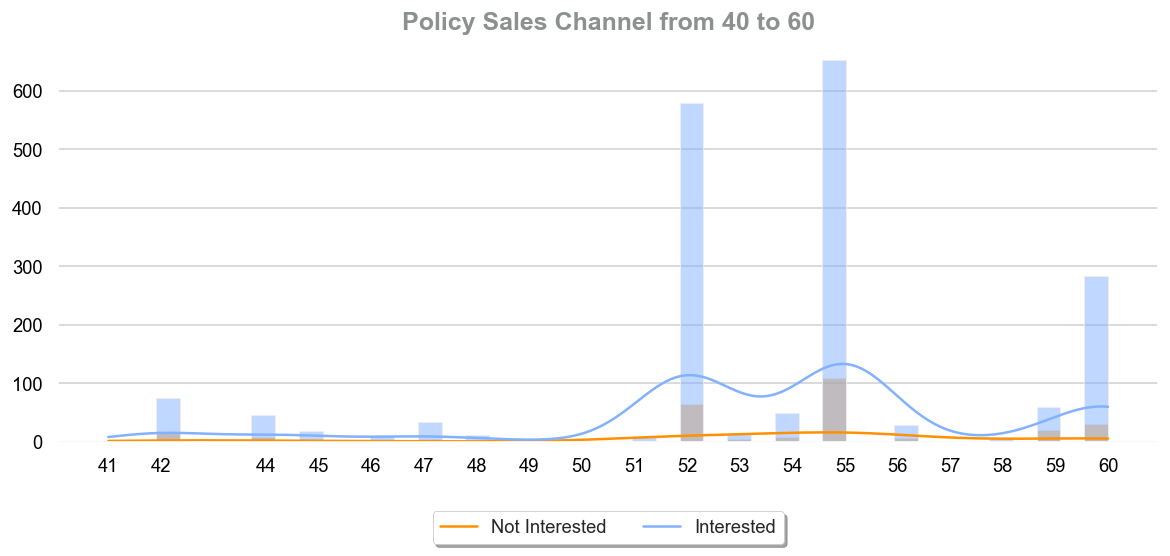

In [38]:
##### DATA FILTERING #####
df_psc60 = df4[ (df4['policy_sales_channel'] > 40) & (df4['policy_sales_channel'] <= 60)]

##### CHART CREATION #####
fig, ax = plt.subplots(figsize=(10, 5)) # Define the figure and axis for the graph

sns.histplot(data=df_psc60, x='policy_sales_channel', kde=True, hue='response', ax=ax) # creating the graph

##### SETTING THE AXIS X LABELS ( TO APPEAR AL NUMBERS) #####

# Obtaining the values for 'region_code'
unique_psc = sorted(df_psc60['policy_sales_channel'].unique())

# Setting unique values as ticks do eixo x
plt.xticks(ticks=unique_psc)

##### HIDE ELEMENTS #####
# Hide only the vertical grid lines
ax.grid(axis='x', linestyle='None') # Hide only the vertical grid line
ax.set_xlabel(None) # Hide x label
ax.set_ylabel(None) # Hide y label

##### ADD A PERSONALIZED LEGEND #####

# Define explicit labels for the legend
legend_labels = ['Not Interested', 'Interested']

# Move the legend below the plot
ax.legend(labels=legend_labels, loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=2)

##### TITLE #####
# Calculate the midpoint of the x-axis
x_midpoint = (ax.get_xlim()[0] + ax.get_xlim()[1]) / 2 # Calculate the midpoint of the y-axis
y_top = (ax.get_ylim()[0] + ax.get_ylim()[1]) + 50     # Add the title at the top of the axes

ax.text(x_midpoint, y_top, s='Policy Sales Channel from 40 to 60', fontsize=15, color='#8C908F', weight='bold', ha='center', va='top')

# PLOT
plt.tight_layout()
plt.show()

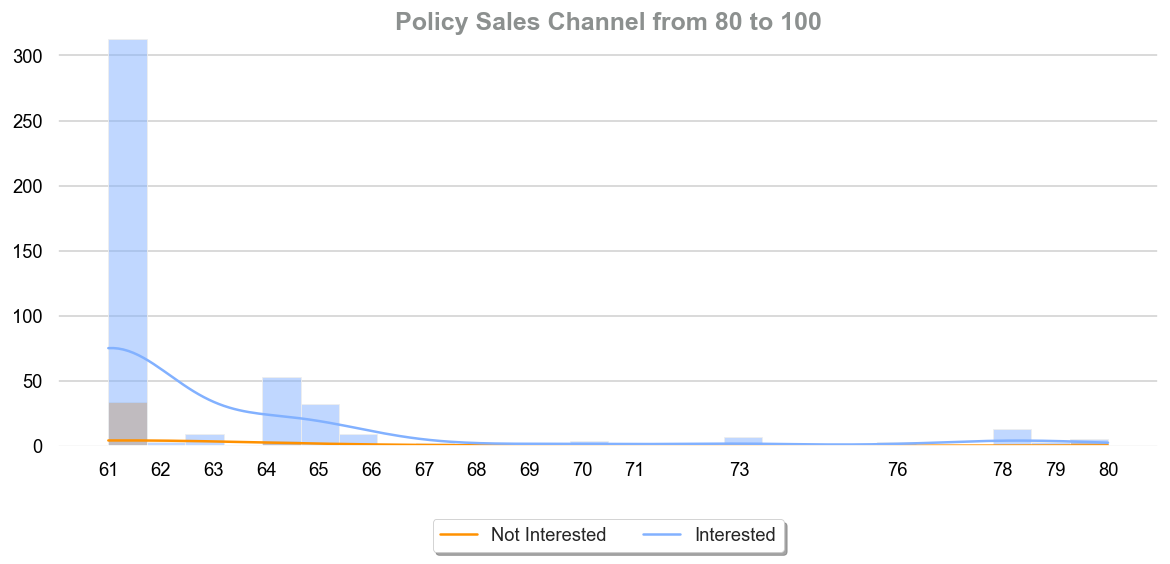

In [39]:
##### DATA FILTERING #####
df_psc80 = df4[ (df4['policy_sales_channel'] > 60) & (df4['policy_sales_channel'] <= 80)]

##### CHART CREATION #####
fig, ax = plt.subplots(figsize=(10, 5)) # Define the figure and axis for the graph

sns.histplot(data=df_psc80, x='policy_sales_channel', kde=True, hue='response', ax=ax) # creating the graph

##### SETTING THE AXIS X LABELS ( TO APPEAR AL NUMBERS) #####

# Obtaining the values for 'region_code'
unique_psc = sorted(df_psc80['policy_sales_channel'].unique())

# Setting unique values as ticks do eixo x
plt.xticks(ticks=unique_psc)

##### HIDE ELEMENTS #####
# Hide only the vertical grid lines
ax.grid(axis='x', linestyle='None') # Hide only the vertical grid line
ax.set_xlabel(None) # Hide x label
ax.set_ylabel(None) # Hide y label

##### ADD A PERSONALIZED LEGEND #####

# Define explicit labels for the legend
legend_labels = ['Not Interested', 'Interested']

# Move the legend below the plot
ax.legend(labels=legend_labels, loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=2)

##### TITLE #####
# Calculate the midpoint of the x-axis
x_midpoint = (ax.get_xlim()[0] + ax.get_xlim()[1]) / 2 # Calculate the midpoint of the y-axis
y_top = (ax.get_ylim()[0] + ax.get_ylim()[1]) + 5 # Add the title at the top of the axes

ax.text(x_midpoint, y_top, s='Policy Sales Channel from 80 to 100', fontsize=15, color='#8C908F', weight='bold', ha='center', va='top')

# PLOT
plt.tight_layout()
plt.show()

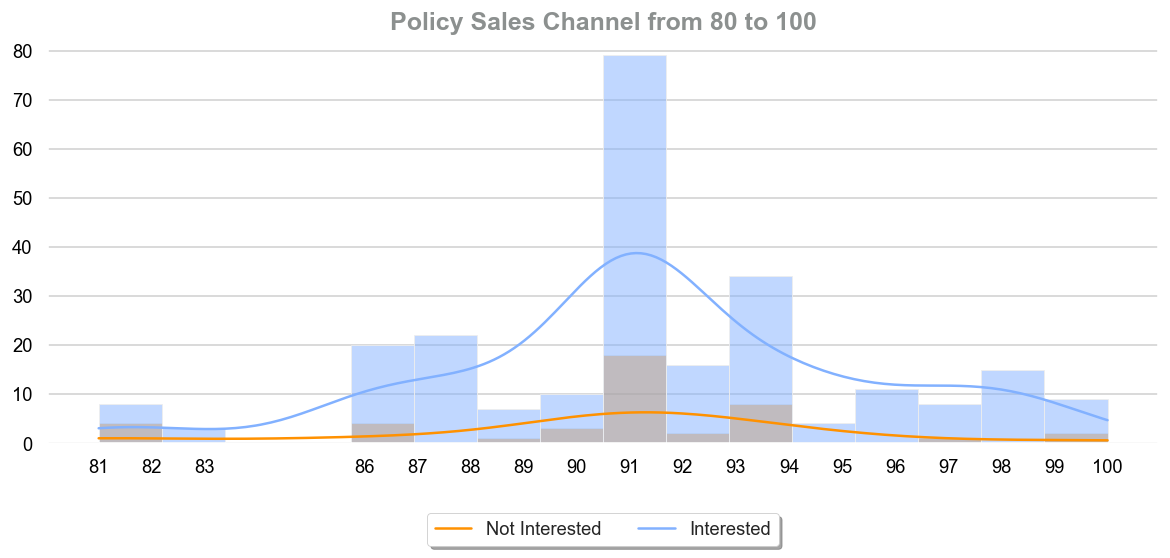

In [40]:
##### DATA FILTERING #####
df_psc100 = df4[ (df4['policy_sales_channel'] > 80) & (df4['policy_sales_channel'] <= 100)]

##### CHART CREATION #####
fig, ax = plt.subplots(figsize=(10, 5)) # Define the figure and axis for the graph

sns.histplot(data=df_psc100, x='policy_sales_channel', kde=True, hue='response', ax=ax) # creating the graph

##### SETTING THE AXIS X LABELS ( TO APPEAR AL NUMBERS) #####

# Obtaining the values for 'region_code'
unique_psc = sorted(df_psc100['policy_sales_channel'].unique())

# Setting unique values as ticks do eixo x
plt.xticks(ticks=unique_psc)

##### HIDE ELEMENTS #####
# Hide only the vertical grid lines
ax.grid(axis='x', linestyle='None') # Hide only the vertical grid line

ax.set_xlabel(None) # Hide x label
ax.set_ylabel(None) # Hide y label

##### ADD A PERSONALIZED LEGEND #####

# Define explicit labels for the legend
legend_labels = ['Not Interested', 'Interested']

# Move the legend below the plot
ax.legend(labels=legend_labels, loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=2)

##### TITLE #####
# Calculate the midpoint of the x-axis
x_midpoint = (ax.get_xlim()[0] + ax.get_xlim()[1]) / 2 # Calculate the midpoint of the y-axis
y_top = (ax.get_ylim()[0] + ax.get_ylim()[1]) + 5 # Add the title at the top of the axes

ax.text(x_midpoint, y_top, s='Policy Sales Channel from 80 to 100', fontsize=15, color='#8C908F', weight='bold', ha='center', va='top')

# PLOT
plt.tight_layout()
plt.show()

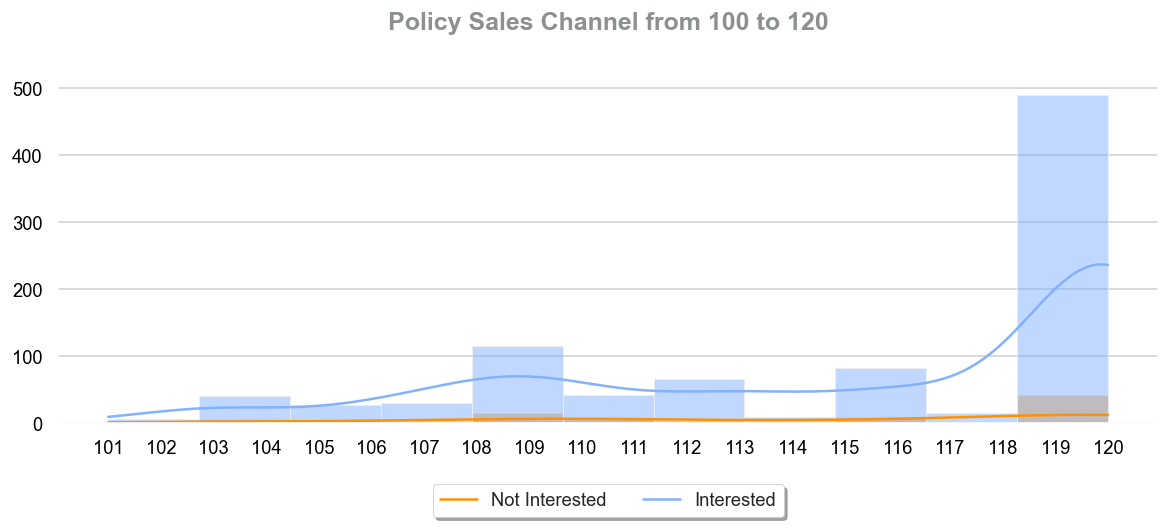

In [41]:
##### DATA FILTERING #####
df_psc120 = df4[ (df4['policy_sales_channel'] > 100) & (df4['policy_sales_channel'] <= 120)]

##### CHART CREATION #####
fig, ax = plt.subplots(figsize=(10, 5)) # Define the figure and axis for the graph

sns.histplot(data=df_psc120, x='policy_sales_channel', kde=True, hue='response', ax=ax) # creating the graph

##### SETTING THE AXIS X LABELS ( TO APPEAR AL NUMBERS) #####

# Obtaining the values for 'region_code'
unique_psc = sorted(df_psc120['policy_sales_channel'].unique())

# Setting unique values as ticks do eixo x
plt.xticks(ticks=unique_psc)

##### HIDE ELEMENTS #####
# Hide only the vertical grid lines
ax.grid(axis='x', linestyle='None') # Hide only the vertical grid line
ax.set_xlabel(None) # Hide x label
ax.set_ylabel(None) # Hide y label

##### ADD A PERSONALIZED LEGEND #####

# Define explicit labels for the legend
legend_labels = ['Not Interested', 'Interested']

# Move the legend below the plot
ax.legend(labels=legend_labels, loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=2)

##### TITLE #####
# Calculate the midpoint of the x-axis
x_midpoint = (ax.get_xlim()[0] + ax.get_xlim()[1]) / 2 # Calculate the midpoint of the y-axis
y_top = (ax.get_ylim()[0] + ax.get_ylim()[1]) + 100 # Add the title at the top of the axes

ax.text(x_midpoint, y_top, s='Policy Sales Channel from 100 to 120', fontsize=15, color='#8C908F', weight='bold', ha='center', va='top')

# PLOT
plt.tight_layout()
plt.show()

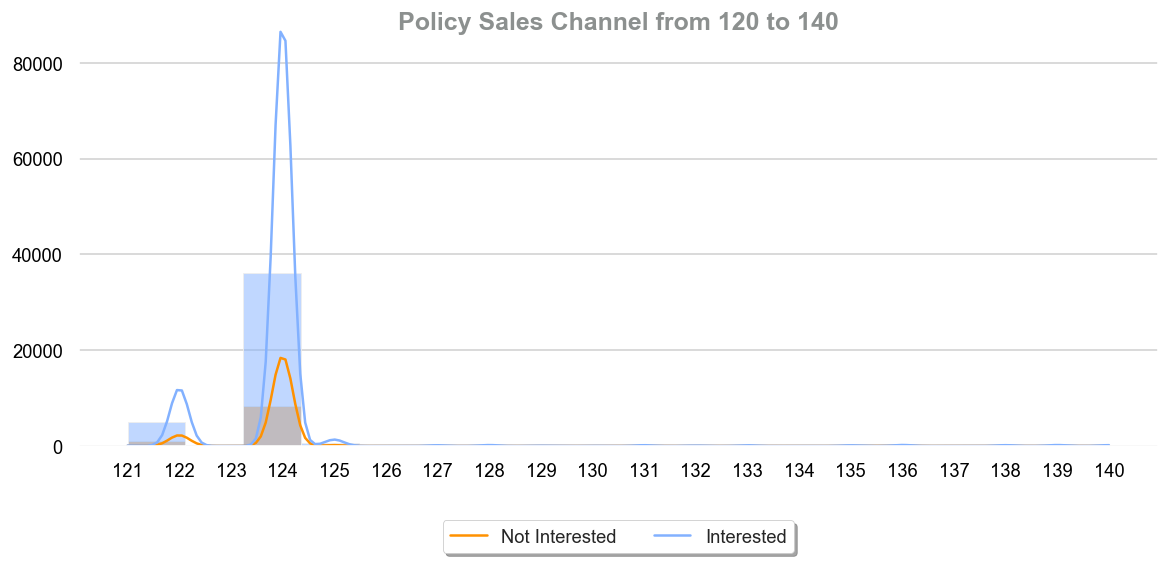

In [42]:
##### DATA FILTERING #####
df_psc140 = df4[ (df4['policy_sales_channel'] > 120) & (df4['policy_sales_channel'] <= 140)]
##### CHART CREATION #####
fig, ax = plt.subplots(figsize=(10, 5)) # Define the figure and axis for the graph

sns.histplot(data=df_psc140, x='policy_sales_channel', kde=True, hue='response', ax=ax) # creating the graph

##### SETTING THE AXIS X LABELS ( TO APPEAR AL NUMBERS) #####

# Obtaining the values for 'region_code'
unique_psc = sorted(df_psc140['policy_sales_channel'].unique())

# Setting unique values as ticks do eixo x
plt.xticks(ticks=unique_psc)

##### HIDE ELEMENTS #####
# Hide only the vertical grid lines
ax.grid(axis='x', linestyle='None') # Hide only the vertical grid line
ax.set_xlabel(None) # Hide x label
ax.set_ylabel(None) # Hide y label

##### ADD A PERSONALIZED LEGEND #####

# Define explicit labels for the legend
legend_labels = ['Not Interested', 'Interested']

# Move the legend below the plot
ax.legend(labels=legend_labels, loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=2)

##### TITLE #####
# Calculate the midpoint of the x-axis
x_midpoint = (ax.get_xlim()[0] + ax.get_xlim()[1]) / 2 # Calculate the midpoint of the y-axis
y_top = (ax.get_ylim()[0] + ax.get_ylim()[1]) + 10 # Add the title at the top of the axes

ax.text(x_midpoint, y_top, s='Policy Sales Channel from 120 to 140', fontsize=15, color='#8C908F', weight='bold', ha='center', va='top')

# PLOT
plt.tight_layout()
plt.show()

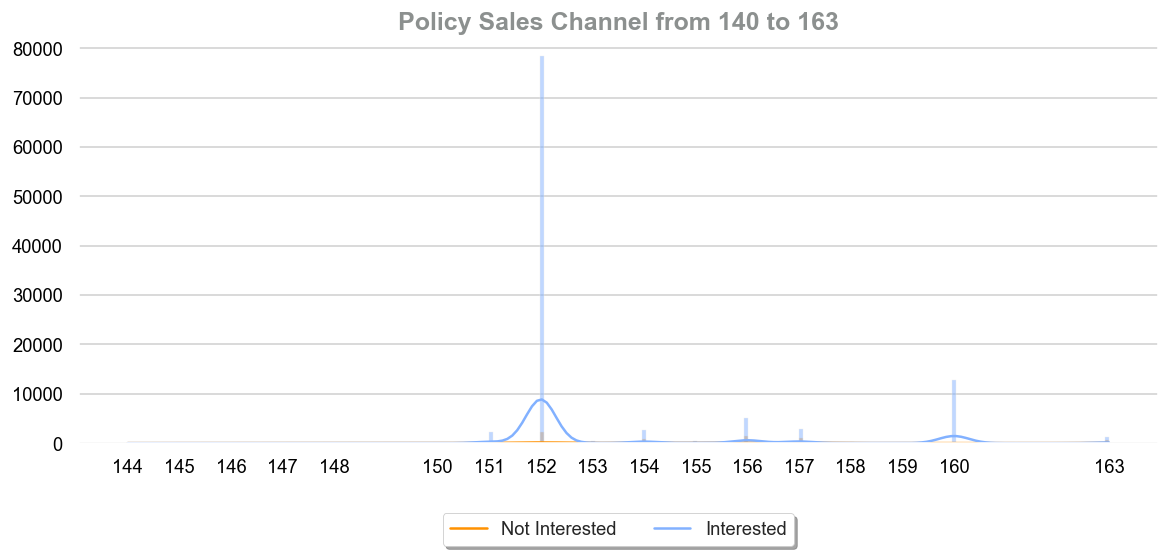

In [43]:
##### DATA FILTERING #####
df_psc160 = df4[ (df4['policy_sales_channel'] > 140) & (df4['policy_sales_channel'] <= 200)]

##### CHART CREATION #####
fig, ax = plt.subplots(figsize=(10, 5)) # Define the figure and axis for the graph

sns.histplot(data=df_psc160, x='policy_sales_channel', kde=True, hue='response', ax=ax) # creating the graph

##### SETTING THE AXIS X LABELS ( TO APPEAR AL NUMBERS) #####

# Obtaining the values for 'region_code'
unique_psc = sorted(df_psc160['policy_sales_channel'].unique())

# Setting unique values as ticks do eixo x
plt.xticks(ticks=unique_psc)

##### HIDE ELEMENTS #####
# Hide only the vertical grid lines
ax.grid(axis='x', linestyle='None') # Hide only the vertical grid line
ax.set_xlabel(None) # Hide x label
ax.set_ylabel(None) # Hide y label

##### ADD A PERSONALIZED LEGEND #####

# Define explicit labels for the legend
legend_labels = ['Not Interested', 'Interested']

# Move the legend below the plot
ax.legend(labels=legend_labels, loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=2)

##### TITLE #####
# Calculate the midpoint of the x-axis
x_midpoint = (ax.get_xlim()[0] + ax.get_xlim()[1]) / 2 # Calculate the midpoint of the y-axis
y_top = (ax.get_ylim()[0] + ax.get_ylim()[1]) + 5000 # Add the title at the top of the axes

ax.text(x_midpoint, y_top, s='Policy Sales Channel from 140 to 163', fontsize=15, color='#8C908F', weight='bold', ha='center', va='top')

# PLOT
plt.tight_layout()
plt.show()

#### 4.1.3 - Num. Feature: driving_license

It is possible to identify that almost all clients have driving license. However there are a small number of customers that own a car but does not have driving license. The company could consider promotions or strategies to attract more customers with this profile.

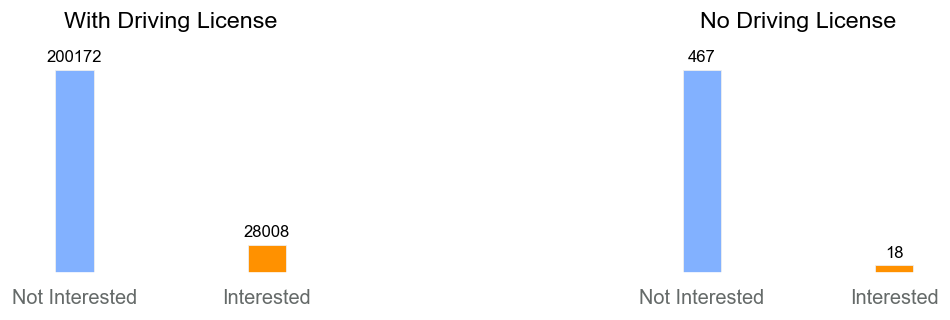

In [44]:
##### DATA FILTERING #####
df_dl = df4[['id','response','driving_license']].groupby(['driving_license','response']).count().reset_index()

df_dl_0 = df_dl[df_dl['driving_license'] == 0 ]
df_dl_1 = df_dl[df_dl['driving_license'] == 1 ]

##### AXIS X LABEL DEFINITION #####
label = ['Not Interested','Interested']

##### CHART CREATION #####
# Defining the figure and axis for the bar chart
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))

# Defining a vetor for each element 
x = np.array(range(1, df_dl_0.shape[0]+1))

# Plot the bars
wb = 0.20 # set the width of the bars

# Plotting bars with orange color for the first bar in each subplot
ydl = ax1.bar(x=x, height='id', data=df_dl_1, width=wb, label='With Driving License', color=['#82B1FF'] + ['#FF9100']*(len(x)-1))
ndl = ax2.bar(x=x, height='id', data=df_dl_0, width=wb, label='No Drivign License', color=['#82B1FF'] + ['#FF9100']*(len(x)-1))

##### HIDE ELEMENTS OF CHART #####

# HIDE GRID
ax1.grid(False) # hiding the grid
ax2.grid(False) # hiding the grid

# HIDE Y AXIS IN BOTH
ax1.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
ax2.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)#


# ##### ADD & EDITING TEXT ELEMENTS #####

# # Labels of the axis X

ax1.set_xticks(x)
ax1.set_xticklabels(label, fontsize=12, color='#656A69');

ax2.set_xticks(x)
ax2.set_xticklabels(label, fontsize=12, color='#656A69');

# Title
# Add titles using plt.text()
plt.text(x=0.5, y=1.15, s='With Driving License', fontsize=14, color='black', ha='center', transform=ax1.transAxes);
plt.text(x=0.5, y=1.15, s='No Driving License', fontsize=14, color='black', ha='center', transform=ax2.transAxes);

# Add labels for each bar in the second subplot
for bar in ndl:
    height = bar.get_height()
    ax2.annotate('{}'.format(height),
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom',
                fontsize=10, color='black')
for bar in ydl:
    height = bar.get_height()
    ax1.annotate('{}'.format(height),
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom',
                fontsize=10, color='black')

fig.tight_layout()
plt.show()

#### 4.1.4 - Num.  Feature: previously_insured

The largest volume of customers had been insured, however the ones that had not been insured before shows an greater interest in buying the new product. Another insight where the company can adopt strategies or promotions to attract more customers with both profiles.

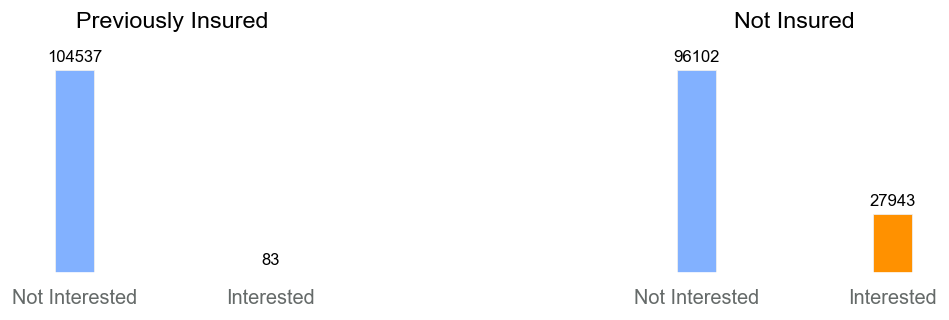

In [45]:
##### DATA FILTERING #####
df_pi = df4[['id','previously_insured','response']].groupby(['previously_insured','response']).count().reset_index()

df_pi_0 = df_pi[df_pi['previously_insured'] == 0 ]
df_pi_1 = df_pi[df_pi['previously_insured'] == 1 ]

##### AXIS X LABEL DEFINITION #####
label = ['Not Interested','Interested']

##### CHART CREATION #####
# Defining the figure and axis for the bar chart
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))

# Defining a vetor for each element 
x = np.array(range(1, df_pi_0.shape[0]+1))

# Plot the bars
wb = 0.20 # set the width of the bars

# Plotting bars with orange color for the first bar in each subplot
ypi = ax1.bar(x=x, height='id', data=df_pi_1, width=wb, label='Previously Insured', color=['#82B1FF'] + ['#FF9100']*(len(x)-1))
npi = ax2.bar(x=x, height='id', data=df_pi_0, width=wb, label='Not Insured', color=['#82B1FF'] + ['#FF9100']*(len(x)-1))

##### HIDE ELEMENTS OF CHART #####

# HIDE GRID
ax1.grid(False) # hiding the grid
ax2.grid(False) # hiding the grid

# HIDE Y AXIS IN BOTH
ax1.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
ax2.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)#


# ##### ADD & EDITING TEXT ELEMENTS #####

# # Labels of the axis X

ax1.set_xticks(x)
ax1.set_xticklabels(label, fontsize=12, color='#656A69');

ax2.set_xticks(x)
ax2.set_xticklabels(label, fontsize=12, color='#656A69');

# Title
# Add titles using plt.text()
plt.text(x=0.5, y=1.15, s='Previously Insured', fontsize=14, color='black', ha='center', transform=ax1.transAxes);
plt.text(x=0.5, y=1.15, s='Not Insured', fontsize=14, color='black', ha='center', transform=ax2.transAxes);

# Add labels for each bar in the second subplot
for bar in npi:
    height = bar.get_height()
    ax2.annotate('{}'.format(height),
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom',
                fontsize=10, color='black')
for bar in ypi:
    height = bar.get_height()
    ax1.annotate('{}'.format(height),
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom',
                fontsize=10, color='black')

fig.tight_layout()
plt.show()

#### 4.1.5 - Num. Feature: vintage

I can't see much relevant information on this chart, the only thing is kind of a pattern on the dates and volum of customers that the company absorves.

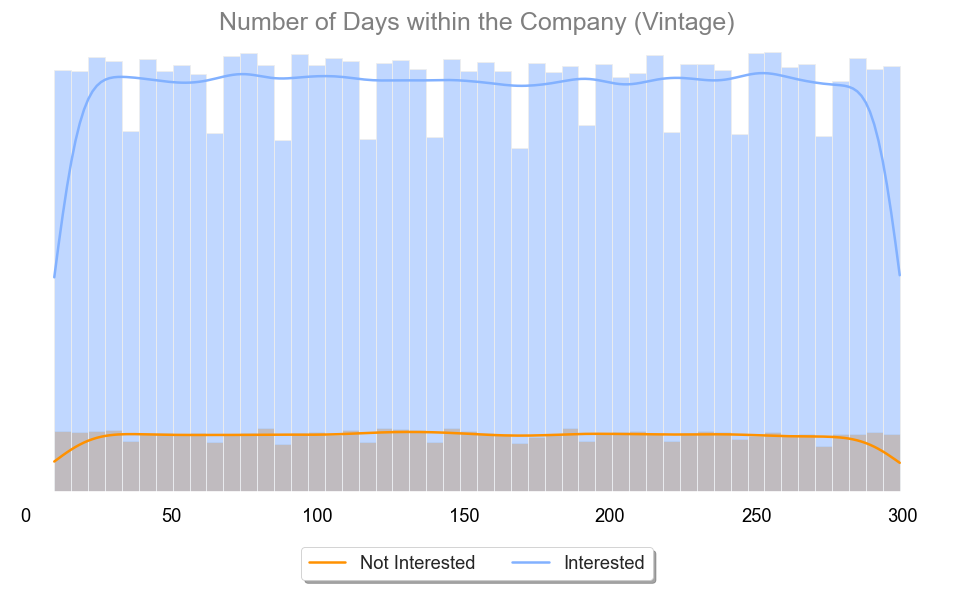

In [46]:
##### CHART CREATION #####
# Defining the figure and axis for the bar chart
fig, ax = plt.subplots(figsize=(10, 5))

# Plotting the histogram
sns.histplot(data=df4, x='vintage', kde=True, hue='response', bins=50, ax=ax)

##### HIDE ELEMENTS OF CHART #####

# HIDE GRID
ax.grid(False) # Hide Grid

plt.gca().axes.get_yaxis().set_visible(False) # Hide y axis

# Remove the x-axis label
ax.set_xlabel(None)

##### TITLE #####
x_midpoint = (ax.get_xlim()[0] + ax.get_xlim()[1]) / 2 # Calculate the midpoint of the y-axis
y_top = (ax.get_ylim()[0] + ax.get_ylim()[1]) # Add the title at the top of the axes
plt.text(x_midpoint, y_top, s='Number of Days within the Company (Vintage)', fontsize=15, color='Grey', ha='center')

# Define explicit labels for the legend
legend_labels = ['Not Interested', 'Interested']

# Move the legend below the plot
plt.legend(labels=legend_labels, loc='upper center', bbox_to_anchor=(0.5, -0.10), fancybox=True, shadow=True, ncol=2)

plt.show()

#### 4.1.6 - Num. Feature: annual_premium

In [47]:
# calculating the percentiles

ap_0 = df4[df4['response'] == 0]
ap_1 = df4[df4['response'] == 1]
perc_0 = ap_0['annual_premium'].describe(percentiles=[.25, .5, .75]).loc[['25%', '50%', '75%']]
perc_1 = ap_1['annual_premium'].describe(percentiles=[.25, .5, .75]).loc[['25%', '50%', '75%']]

# Print percentile when customers are not interested
print(f'The annual premium percentiles when the response is 0 are:\n{perc_0}')

# Print percentile when customer are interested
print(f'The annual premium percentiles when the response is 1 are:\n{perc_1}')

The annual premium percentiles when the response is 0 are:
25%    24337.0
50%    31514.0
75%    39145.0
Name: annual_premium, dtype: float64
The annual premium percentiles when the response is 1 are:
25%    24937.5
50%    33009.0
75%    41317.0
Name: annual_premium, dtype: float64


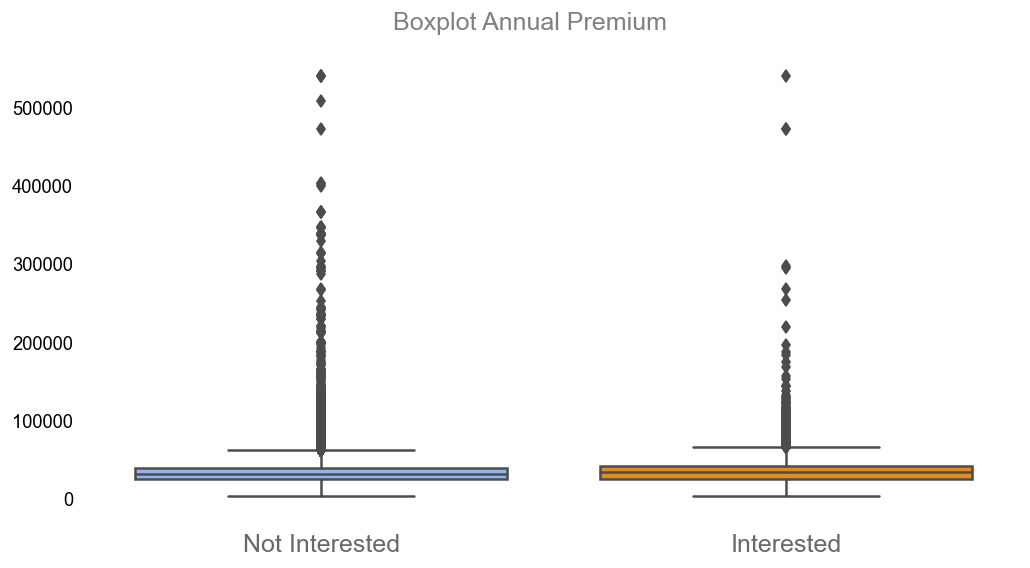

In [48]:
##### CHART CREATIN #####
fig, ax = plt.subplots(figsize=(10, 5))

sns.boxplot(data=df4, x='response',y='annual_premium', ax=ax);

#### HIDE ELEMENTS ####

ax.grid(False) # Hide grid

ax.set_ylabel(None) # Hide y label
ax.set_xlabel(None) # Hide x label

##### DESIGN #####

plt.text(x=0.45, y=600000, s='Boxplot Annual Premium', fontsize=15, color='Grey', ha='center')

label = ['Not Interested','Interested']
ax.set_xticklabels(label, fontsize=15, color='#656A69');

plt.show()

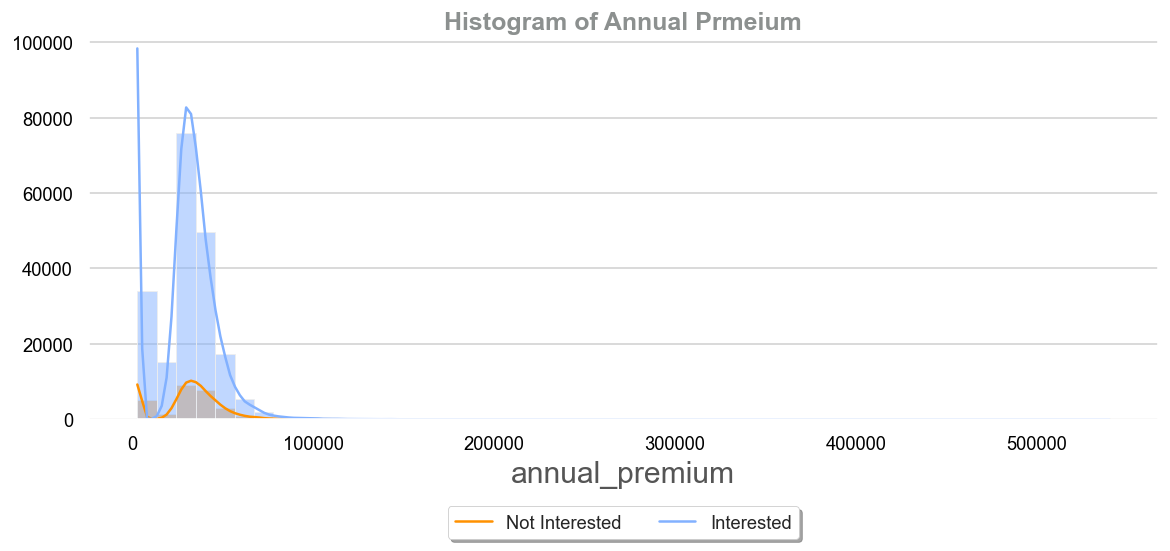

In [49]:
##### CHART CREATION #####
fig, ax = plt.subplots(figsize=(10, 5)) # Define the figure and axis for the graph

sns.histplot(data=df4, x='annual_premium', kde=True, hue='response', bins=50, ax=ax); # creating the graph

##### HIDE ELEMENTS #####
# Hide only the vertical grid lines
ax.grid(axis='x', linestyle='None') # Hide only the vertical grid line
ax.set_ylabel(None) # Hide axis y label

##### ADD A PERSONALIZED LEGEND #####

# Define explicit labels for the legend
legend_labels = ['Not Interested', 'Interested']

# Move the legend below the plot
ax.legend(labels=legend_labels, loc='upper center', bbox_to_anchor=(0.5, -0.20), fancybox=True, shadow=True, ncol=2)

##### TITLE #####
# Calculate the midpoint of the x-axis
x_midpoint = (ax.get_xlim()[0] + ax.get_xlim()[1]) / 2 # Calculate the midpoint of the y-axis
y_top = (ax.get_ylim()[0] + ax.get_ylim()[1]) + 5000 # Add the title at the top of the axes

ax.text(x_midpoint, y_top, s='Histogram of Annual Prmeium', fontsize=15, color='#8C908F', weight='bold', ha='center', va='top')

# PLOT
plt.tight_layout()
plt.show()

On the graphs above, we can identify that 75% of the customers spend up to an approximately value of 41.000 on insurance. And only a small group spend more than 100.000 on the product.

And on the step 1.2.1 I have printed a table with a statistic summary and I realised an min. value of 2630 and an max of 540165.0, I will have a close look to these values.

Through the percentils above, we can identify that 50% of the data are within the interval from 24.000 to 41.500. So I will have a look on the values below 24.000 and above the 41.000.

#### Annual Premium below 24.000

In [50]:
# FILTER FOR ANNUAL PREMIUM BELOW THAN 24.000
aux_24k = df4[df4['annual_premium'] <= 24000]

In [51]:
aux_24k['response'].value_counts()

response
0    48634
1     6524
Name: count, dtype: int64

In [52]:
aux_24k['annual_premium'].describe()

count    55158.000000
mean      8102.561387
std       8624.212932
min       2630.000000
25%       2630.000000
50%       2630.000000
75%      19078.000000
max      24000.000000
Name: annual_premium, dtype: float64

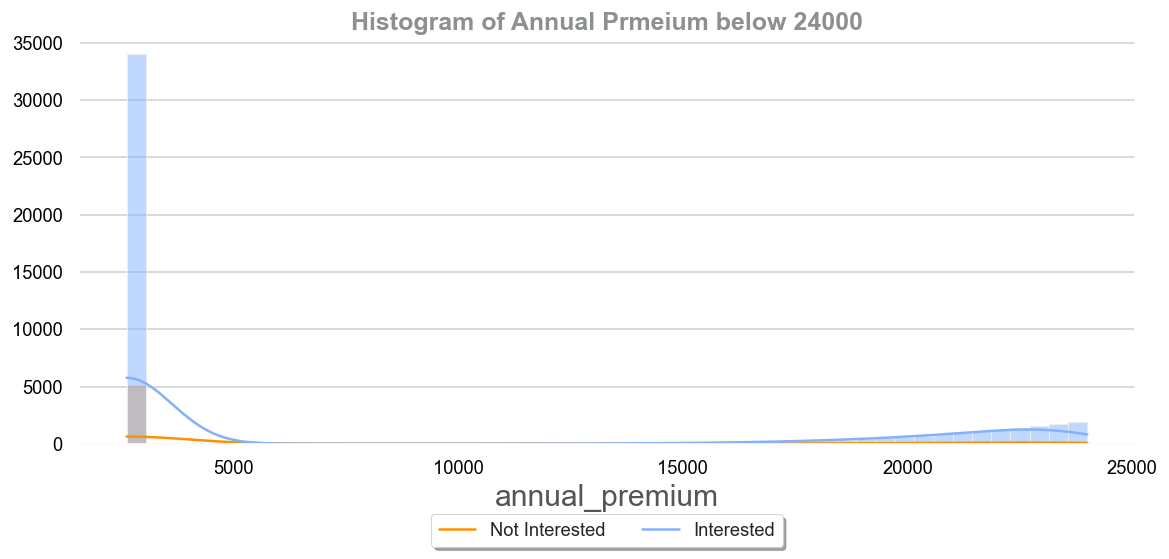

In [53]:
##### CHART CREATION #####
fig, ax = plt.subplots(figsize=(10, 5)) # Define the figure and axis for the graph
sns.histplot(data=aux_24k, x='annual_premium', kde=True, hue='response', bins=50, ax=ax); # creating the graph

##### HIDE ELEMENTS #####
# Hide only the vertical grid lines
ax.grid(axis='x', linestyle='None') # Hide only the vertical grid line
ax.set_ylabel(None) # Hide axis y label

##### ADD A PERSONALIZED LEGEND #####

# Define explicit labels for the legend
legend_labels = ['Not Interested', 'Interested']

# Move the legend below the plot
ax.legend(labels=legend_labels, loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=2)

##### TITLE #####
# Calculate the midpoint of the x-axis
x_midpoint = (ax.get_xlim()[0] + ax.get_xlim()[1]) / 2 # Calculate the midpoint of the y-axis
y_top = (ax.get_ylim()[0] + ax.get_ylim()[1]) + 2000 # Add the title at the top of the axes

ax.text(x_midpoint, y_top, s='Histogram of Annual Prmeium below 24000', fontsize=15, color='#8C908F', weight='bold', ha='center', va='top')

# PLOT
plt.tight_layout()
plt.show()

##### Observation
1. There are 55158 records within the interval from 0 to 24.000; Analysing these data I have identified that 40.000 customers have paid the same amount for their life insurance. I will identify now which value is this and further on I will decide how to handle this.

In [54]:
# Selecting data balow 5000
aux_5000 = df4[df4['annual_premium'] <= 5000] 

In [55]:
aux_5000['response'].value_counts()

response
0    34008
1     5101
Name: count, dtype: int64

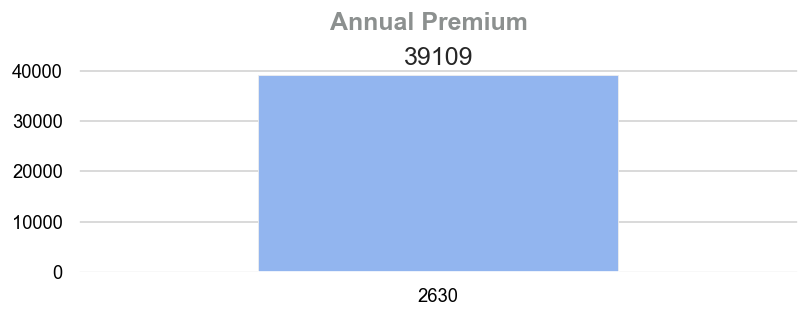

In [56]:
##### CHART CREATION #####

# Defining the figure and axis for the bar chart
fig, ax = plt.subplots(figsize=(7,3))

# Plot the bar
sns.countplot(aux_5000, x="annual_premium", width=0.5, ax=ax)

##### ADD LABELS WITH TOTAL VALUES #####
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

##### DESIGN #####

##### HIDE ELEMENTS OF CHART #####
ax.set_ylabel(None)
ax.set_xlabel(None)
#ax.grid(False) # hiding the grid

# Title
x_pos = (ax.get_xlim()[0] + ax.get_xlim()[1]) - 0.15 # Calculate the midpoint of the y-axis
y_pos = (ax.get_ylim()[0] + ax.get_ylim()[1]) + 7000 # Calculate the midpoint of the y-axis

plt.text(x_pos, y_pos, s='Annual Premium', fontsize=15, color='#8C908F', weight='bold' )

plt.tight_layout()
plt.show()

I have identify 39109 records where these customers have spend the same amount of 2630 on their life insurance. This is a high volum of data and my approach will be:

I will consider all these data and I will evaluate the machine learning model and afterwards, I will compare it's results with another version of the same algorithm, where I will evaluate it filtering these data.

#### Now, let's have a look into the datas from 41.000

In [57]:
aux_41k = df4[(df4['annual_premium'] >= 41000) & (df4['annual_premium'] <= 70000)] 

In [58]:
aux_41k['response'].value_counts()

response
0    39400
1     6770
Name: count, dtype: int64

In [59]:
aux_41k['annual_premium'].describe()

count    46170.000000
mean     49079.055166
std       6847.461829
min      41000.000000
25%      43675.000000
50%      47166.000000
75%      52710.000000
max      69995.000000
Name: annual_premium, dtype: float64

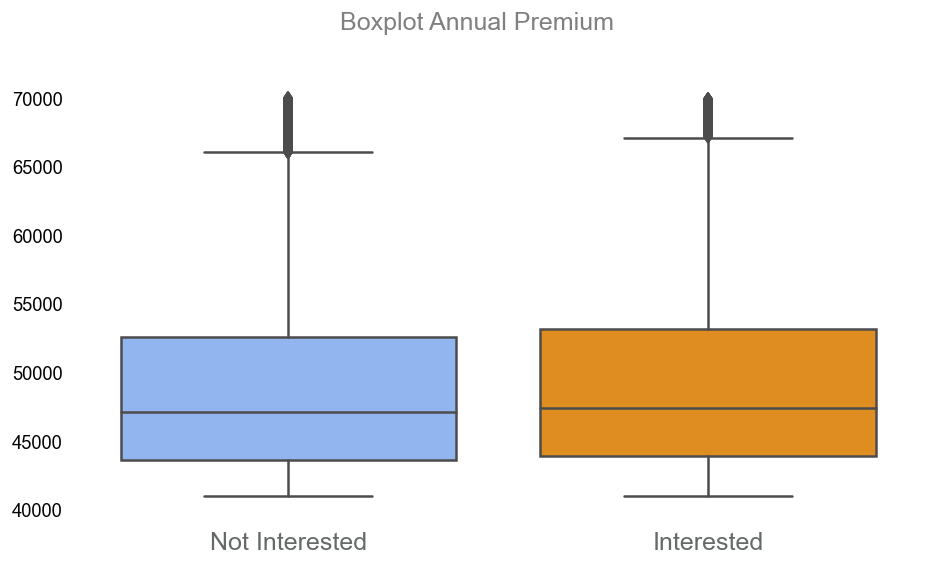

In [60]:
##### CHART CREATION #####
fig, ax = plt.subplots(figsize=(8, 5))
sns.boxplot(data=aux_41k, x='response',y='annual_premium');

#### HIDE ELEMENTS ####

ax.grid(False) # Hide grid

ax.set_ylabel(None) # Hide y label
ax.set_xlabel(None) # Hide x label

##### DESIGN #####

plt.text(x=0.45, y=75000, s='Boxplot Annual Premium', fontsize=15, color='Grey', ha='center')

label = ['Not Interested','Interested']
ax.set_xticklabels(label, fontsize=15, color='#656A69');

plt.tight_layout()
plt.show()

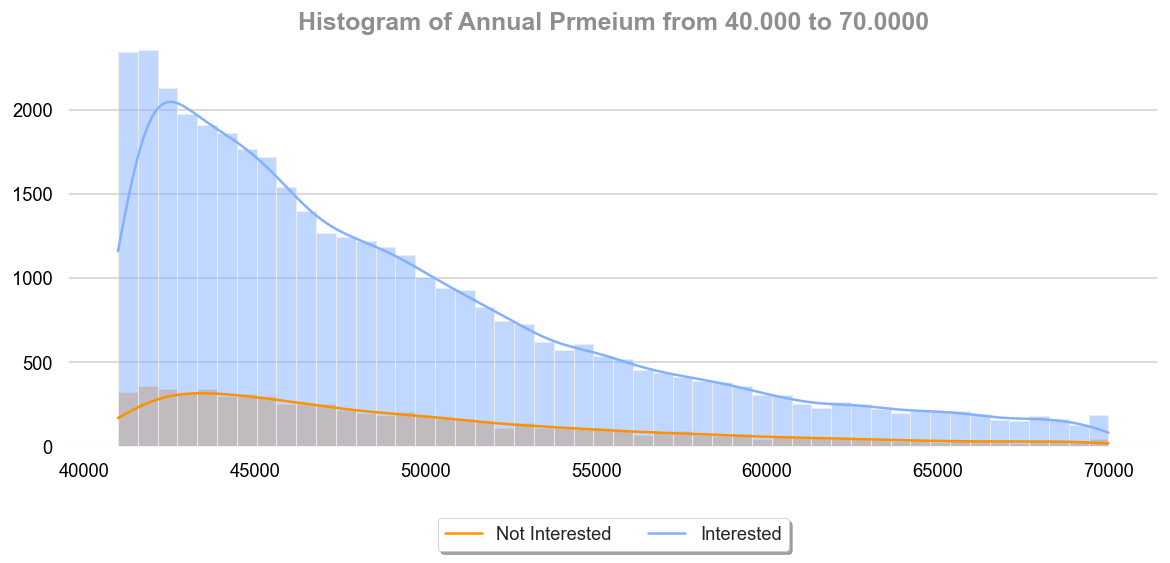

In [61]:
##### CHART CREATION #####
fig, ax = plt.subplots(figsize=(10, 5))

sns.histplot(data=aux_41k, x='annual_premium', kde=True, hue='response', bins=50);

#### DESIGN ####
# HIDE ELEMENTS
ax.grid(axis='x', linestyle='None') # Hide only the vertical grid line
ax.set_xlabel(None) # Hide x label
ax.set_ylabel(None) # Hide y label

# ADD & EDITING TEXT ELEMENTS

# LEGEND
# Define explicit labels for the legend
legend_labels = ['Not Interested', 'Interested']

# Move the legend below the plot
ax.legend(labels=legend_labels, loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=2)

# TITLE
# Calculate the midpoint of the x-axis
x_midpoint = (ax.get_xlim()[0] + ax.get_xlim()[1]) / 2 # Calculate the midpoint of the y-axis
y_top = (ax.get_ylim()[0] + ax.get_ylim()[1]) # Add the title at the top of the axes

plt.text(x_midpoint, y_top, s='Histogram of Annual Prmeium from 40.000 to 70.0000', fontsize=15, color='#8C908F', weight='bold', ha='center')

plt.tight_layout()
plt.show()

##### Observations:

On this interval, the values and the data distribuition seems to be okay, nothing that attract my attendion due distortion os something; I will continue the analysis;

#### Annual Premium above 70000 below 150000

In [62]:
aux_70k = df4[(df4['annual_premium'] >= 70000) & (df4['annual_premium'] <= 150000)] 

In [63]:
aux_70k['annual_premium'].describe()

count      2767.000000
mean      83874.409830
std       14162.111831
min       70010.000000
25%       73363.000000
50%       78948.000000
75%       89879.500000
max      147075.000000
Name: annual_premium, dtype: float64

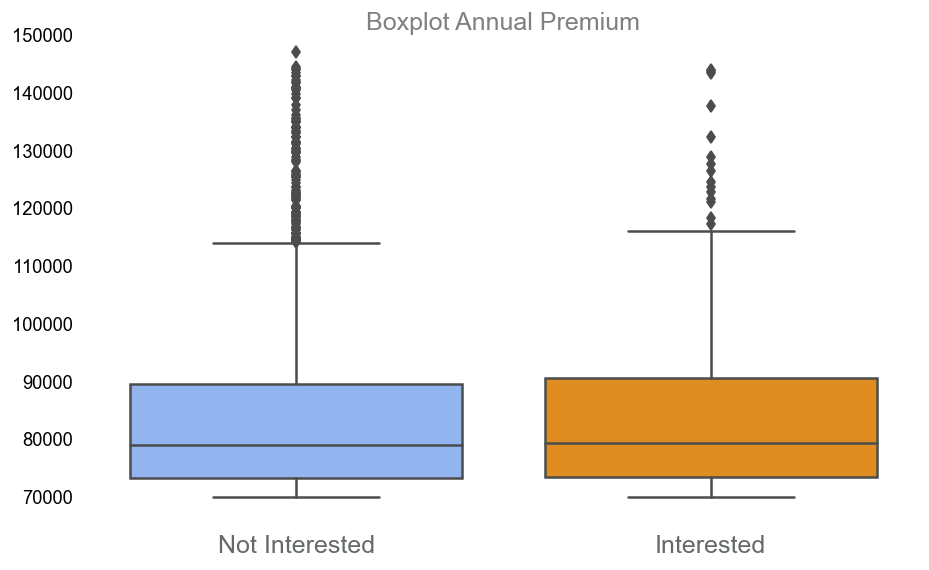

In [64]:
##### CHART CREATION #####
fig, ax = plt.subplots(figsize=(8, 5))
sns.boxplot(data=aux_70k, x='response',y='annual_premium');

#### HIDE ELEMENTS ####

ax.grid(False) # Hide grid

ax.set_ylabel(None) # Hide y label
ax.set_xlabel(None) # Hide x label

##### DESIGN #####
x_pos = (ax.get_xlim()[0] + ax.get_xlim()[1]) / 2 # Calculate the midpoint of the y-axis
y_pos = (ax.get_ylim()[1])                        # Add the title at the top of the axes

plt.text(x_pos, y_pos, s='Boxplot Annual Premium', fontsize=15, color='Grey', ha='center')

label = ['Not Interested','Interested']
ax.set_xticklabels(label, fontsize=15, color='#656A69');

plt.tight_layout()
plt.show()

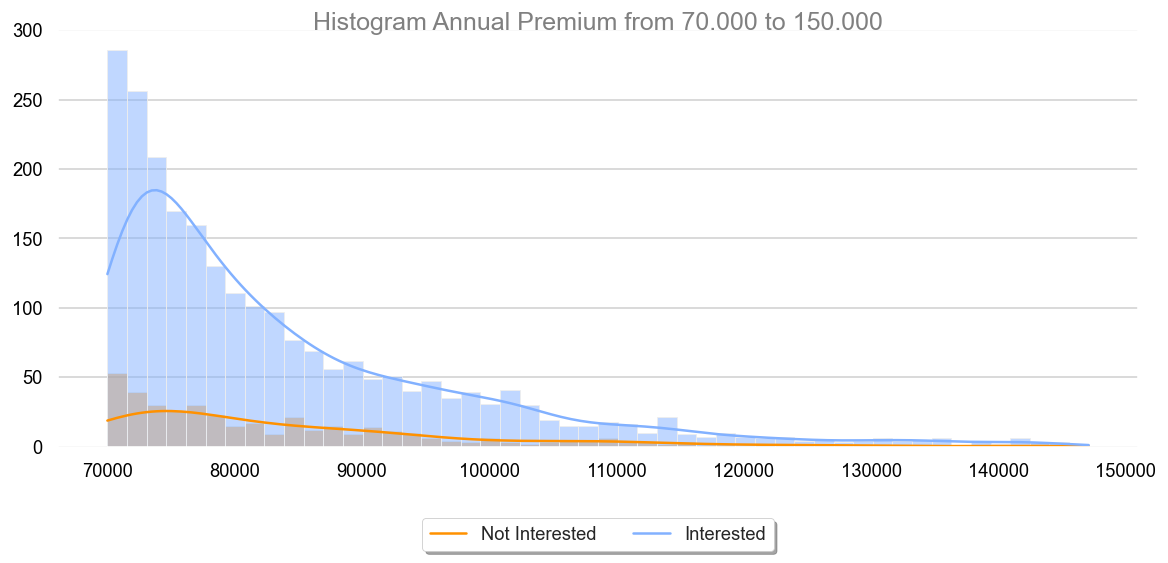

In [65]:
##### CHART CREATION #####
fig, ax = plt.subplots(figsize=(10, 5))
sns.histplot(data=aux_70k, x='annual_premium', kde=True, hue='response', bins=50);

#### DESIGN ####
# HIDE ELEMENTS
ax.grid(axis='x', linestyle='None') # Hide only the vertical grid line
ax.set_xlabel(None) # Hide x label
ax.set_ylabel(None) # Hide y label

# ADD & EDITING TEXT ELEMENTS

# LEGEND
# Define explicit labels for the legend
legend_labels = ['Not Interested', 'Interested']

# Move the legend below the plot
ax.legend(labels=legend_labels, loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=2)

# TEXT
x_pos = (ax.get_xlim()[0] + ax.get_xlim()[1]) / 2 # Calculate the midpoint of the y-axis
y_pos = (ax.get_ylim()[1])                        # Add the title at the top of the axes

plt.text(x_pos, y_pos, s='Histogram Annual Premium from 70.000 to 150.000', fontsize=15, color='Grey', ha='center')

plt.tight_layout()
plt.show()

#### Annual Premium above 150000

In [66]:
aux_150k = df4[df4['annual_premium'] >= 150000]

In [67]:
aux_150k['response'].value_counts()

response
0    95
1    15
Name: count, dtype: int64

In [68]:
aux_150k['annual_premium'].describe()

count       110.000000
mean     254910.600000
std       98535.167057
min      150468.000000
25%      181379.000000
50%      225318.500000
75%      301885.250000
max      540165.000000
Name: annual_premium, dtype: float64

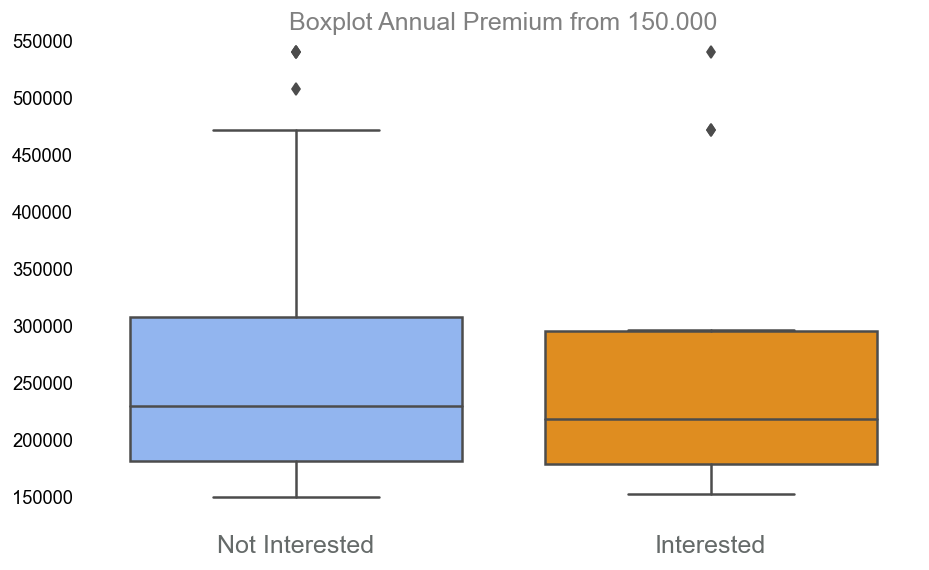

In [69]:

##### CHART CREATION #####
fig, ax = plt.subplots(figsize=(8, 5))
sns.boxplot(data=aux_150k, x='response',y='annual_premium');

#### HIDE ELEMENTS ####

ax.grid(False) # Hide grid

ax.set_ylabel(None) # Hide y label
ax.set_xlabel(None) # Hide x label

##### DESIGN #####
x_pos = (ax.get_xlim()[0] + ax.get_xlim()[1]) / 2 # Calculate the midpoint of the y-axis
y_pos = (ax.get_ylim()[1])                        # Add the title at the top of the axes

plt.text(x_pos, y_pos, s='Boxplot Annual Premium from 150.000', fontsize=15, color='Grey', ha='center')

label = ['Not Interested','Interested']
ax.set_xticklabels(label, fontsize=15, color='#656A69');

plt.tight_layout()
plt.show()

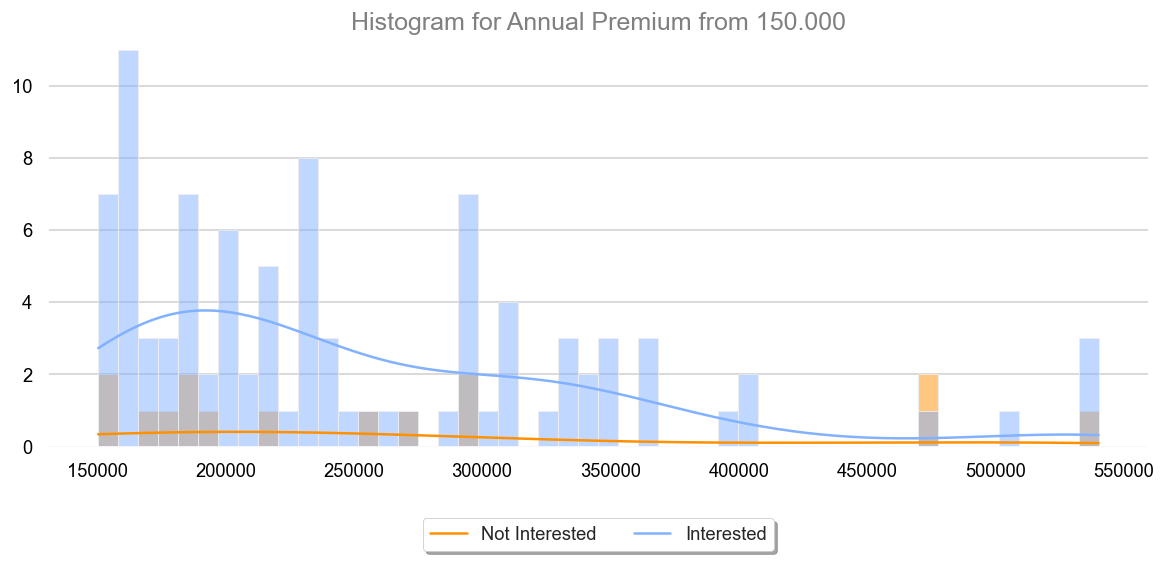

In [70]:

##### CHART CREATION #####
fig, ax = plt.subplots(figsize=(10, 5))
sns.histplot(data=aux_150k, x='annual_premium', kde=True, hue='response', bins=50);

#### DESIGN ####
# HIDE ELEMENTS
ax.grid(axis='x', linestyle='None') # Hide only the vertical grid line
ax.set_xlabel(None) # Hide x label
ax.set_ylabel(None) # Hide y label

# ADD & EDITING TEXT ELEMENTS

# LEGEND
# Define explicit labels for the legend
legend_labels = ['Not Interested', 'Interested']

# Move the legend below the plot
ax.legend(labels=legend_labels, loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=2)

# TEXT
x_pos = (ax.get_xlim()[0] + ax.get_xlim()[1]) / 2 # Calculate the midpoint of the y-axis
y_pos = (ax.get_ylim()[1])                        # Add the title at the top of the axes

plt.text(x_pos, y_pos, s='Histogram for Annual Premium from 150.000', fontsize=15, color='Grey', ha='center')

plt.tight_layout()
plt.show()

##### Observations:

There are 110 records within the interval from 150.000 to 550.000 and only 15 of these represents the interested customers;
I will continue the analysis and further on, I will come back to this step, analyse the insights and decide how to handle these values.

What I am considering is:
    
    1 - If I remove the interested customers that spend more than 150.000 I will loose 15 records, but maybe this might help my algorithm to make better classifications;

#### 4.1.7 - Num. Feature: Age

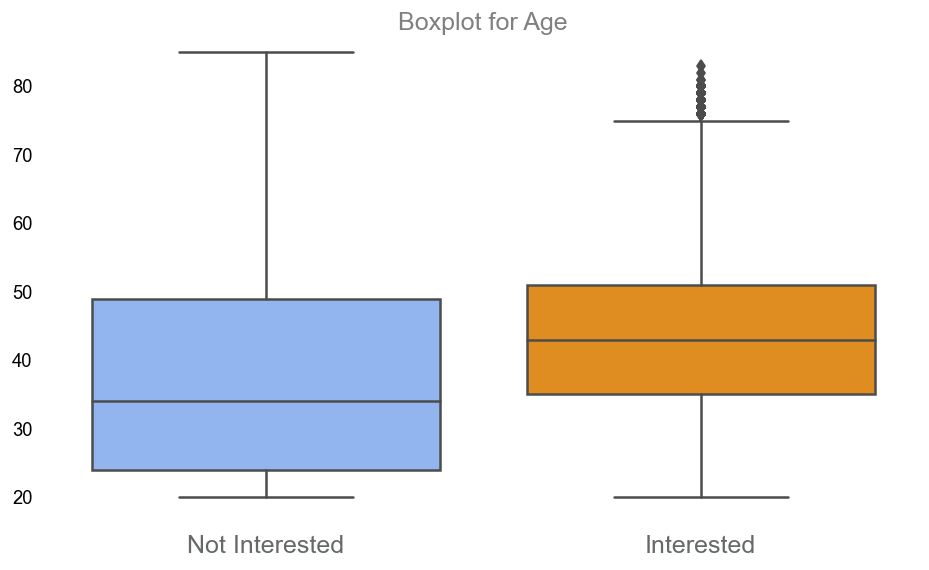

In [71]:
##### CHART CREATION #####
fig, ax = plt.subplots(figsize=(8, 5))
sns.boxplot(data=df4, x='response',y='age');

#### HIDE ELEMENTS ####

ax.grid(False) # Hide grid

ax.set_ylabel(None) # Hide y label
ax.set_xlabel(None) # Hide x label

##### DESIGN #####
x_pos = (ax.get_xlim()[0] + ax.get_xlim()[1]) / 2 # Calculate the midpoint of the y-axis
y_pos = (ax.get_ylim()[1])                        # Add the title at the top of the axes

plt.text(x_pos, y_pos, s='Boxplot for Age', fontsize=15, color='Grey', ha='center')

label = ['Not Interested','Interested']
ax.set_xticklabels(label, fontsize=15, color='#656A69');

plt.tight_layout()
plt.show()

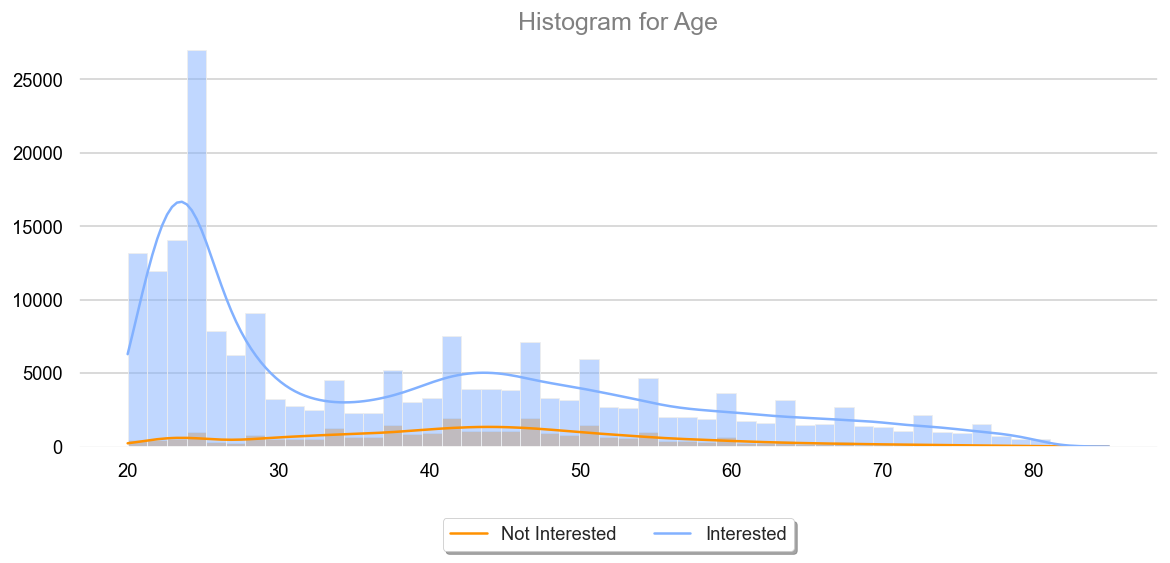

In [72]:
##### CHART CREATION #####
fig, ax = plt.subplots(figsize=(10, 5))
sns.histplot(data=df4, x='age', kde=True, hue='response', bins=50);

#### DESIGN ####
# HIDE ELEMENTS
ax.grid(axis='x', linestyle='None') # Hide only the vertical grid line
ax.set_xlabel(None) # Hide x label
ax.set_ylabel(None) # Hide y label

# ADD & EDITING TEXT ELEMENTS

# LEGEND
# Define explicit labels for the legend
legend_labels = ['Not Interested', 'Interested']

# Move the legend below the plot
ax.legend(labels=legend_labels, loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=2)

# TITLE
x_pos = (ax.get_xlim()[0] + ax.get_xlim()[1]) / 2 # Calculate the midpoint of the y-axis
y_pos = (ax.get_ylim()[1])                        # Add the title at the top of the axes

plt.text(x_pos, y_pos, s='Histogram for Age', fontsize=15, color='Grey', ha='center')

plt.tight_layout()
plt.show()

#### 4.1.9 - Cat. feature: gender

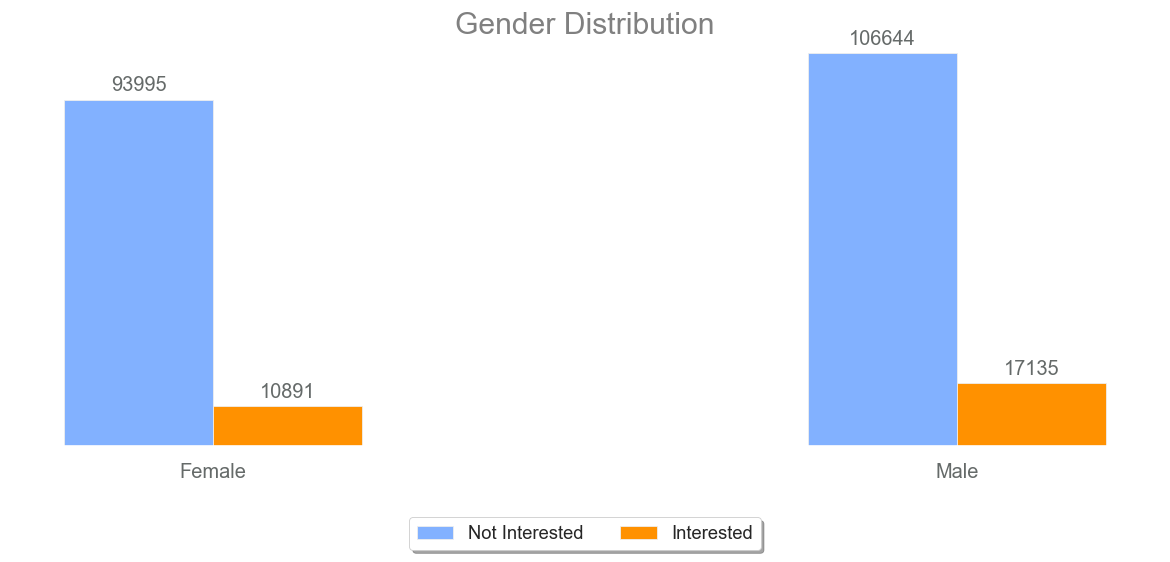

In [73]:
df_cg = df4[['id','gender','response']].groupby(['response','gender']).count().reset_index()
df_cg = df_cg.rename(columns={'id': 'qty'})

df_cg_m = df_cg[df_cg['response']==0]
df_cg_f = df_cg[df_cg['response']==1]

##### CHART CREATION #####

# Defining the figure and axis for the bar chart
fig, ax = plt.subplots(figsize=(10, 5))

# Defining a vetor for each element 
x = np.array(range(1, df_cg_m.shape[0]+1))

# Plot the bars
wb = 0.20 # set the width of the bars
mcg = ax.bar(x=x-wb/2, height='qty', data=df_cg_m, width=wb) # ploting the bars into the left
fcg = ax.bar(x=x+wb/2, height='qty', data=df_cg_f, width=wb) # ploting the bars into the right

##### DESIGN #####

##### HIDE ELEMENTS OF CHART #####
ax.grid(False) # hiding the grid
plt.gca().axes.get_yaxis().set_visible(False) # Hide y axis|

##### ADD & EDITING TEXT ELEMENTS #####

# AXIS X LABEL DEFINITION
label = ['Female','Male']

ax.set_xticks(x)
ax.set_xticklabels(label, fontsize=12, color='#656A69');

# TITLE
x_pos = (ax.get_xlim()[0] + ax.get_xlim()[1]) / 2 # Calculate the midpoint of the y-axis
y_pos = (ax.get_ylim()[1])                        # Add the title at the top of the axes

plt.text(x_pos, y_pos, s='Gender Distribution', fontsize=18, color='Grey', ha='center')

# LEGEND
legend_labels = ['Not Interested', 'Interested']   # Define explicit labels for the legend
ax.legend(labels=legend_labels, loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=2) # Move the legend below the plot

def add_bar_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate('{}'.format(height), xy=(bar.get_x() + bar.get_width() / 2, height), xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=12, color='#656A69')
        
add_bar_labels(mcg)
add_bar_labels(fcg)        

fig.tight_layout()
plt.show()

#### 4.1.10 - Cat. Feature: vehicle_age

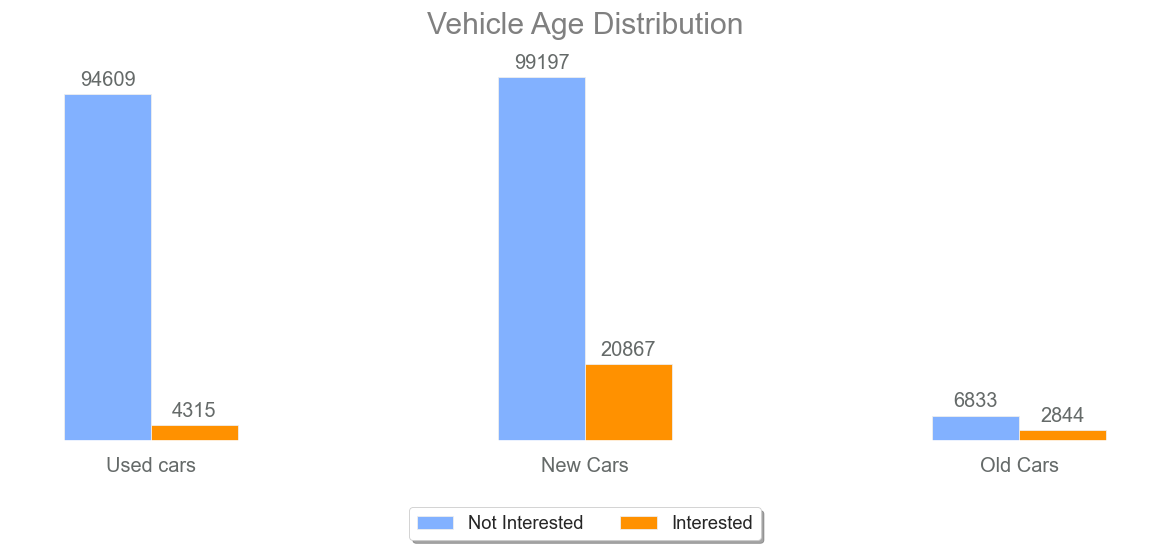

In [74]:
##### DATA FILTERING #####
df_va = df4[['id','vehicle_age','response']].groupby(['response','vehicle_age']).count().reset_index()
df_va = df_va.rename(columns={'id': 'qty'})

df_va0 = df_va[df_va['response']==0]
df_va1 = df_va[df_va['response']==1]

##### CHART CREATION #####

# Defining the figure and axis for the bar chart
fig, ax = plt.subplots(figsize=(10, 5))

# Defining a vetor for each element 
x = np.array(range(1, df_va0.shape[0]+1))

# Plot the bars
wb = 0.20 # set the width of the bars
br = ax.bar(x=x-wb/2, height='qty', data=df_va0, width=wb) # ploting the bars into the left
bl = ax.bar(x=x+wb/2, height='qty', data=df_va1, width=wb) # ploting the bars into the right

##### DESIGN #####

##### HIDE ELEMENTS OF CHART #####
ax.grid(False) # hiding the grid
plt.gca().axes.get_yaxis().set_visible(False) # Hide y axis

##### ADD & EDITING TEXT ELEMENTS #####

# AXIS X LABEL DEFINITION
label = ['Used cars','New Cars', 'Old Cars']
ax.set_xticks(x)
ax.set_xticklabels(label, fontsize=12, color='#656A69');

# TITLE
x_pos = (ax.get_xlim()[0] + ax.get_xlim()[1]) / 2 # Calculate the midpoint of the y-axis
y_pos = (ax.get_ylim()[1]) + 7000                  # Add the title at the top of the axes
plt.text(x_pos, y_pos, s='Vehicle Age Distribution', fontsize=18, color='Grey', ha='center')

# LEGEND
legend_labels = ['Not Interested', 'Interested']   # Define explicit labels for the legend
ax.legend(labels=legend_labels, loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=2) # Move the legend below the plot

def add_bar_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate('{}'.format(height), xy=(bar.get_x() + bar.get_width() / 2, height), xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=12, color='#656A69')
        
add_bar_labels(br)
add_bar_labels(bl)        

fig.tight_layout()
plt.show()

#### 4.1.11 - Cat. Feature: vehicle_damage

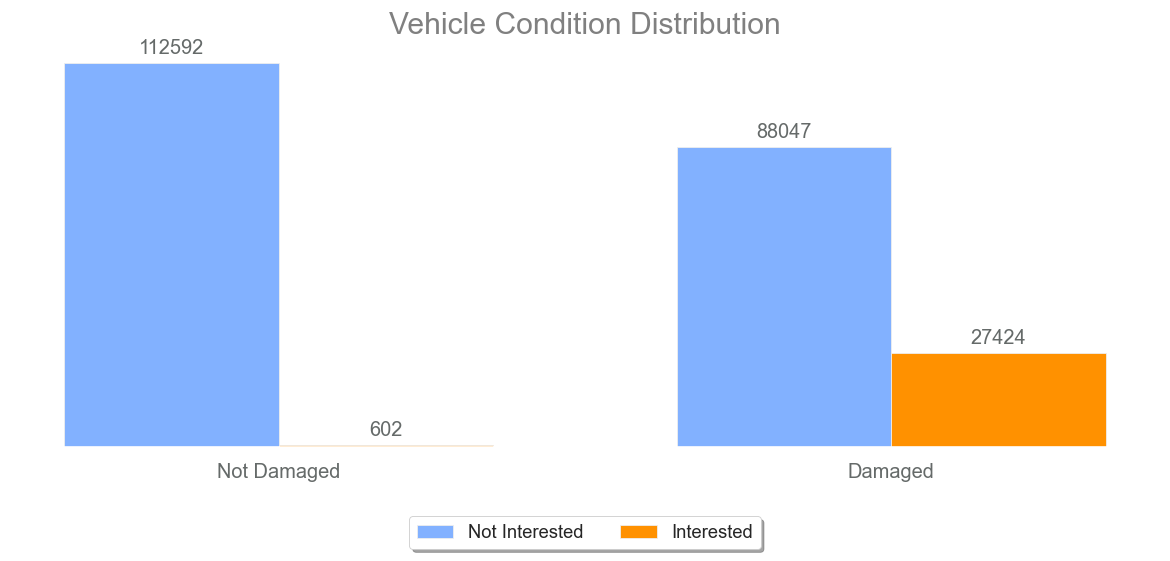

In [75]:
##### DATA FILTERING #####
df_vd = df4[['id','vehicle_damage','response']].groupby(['response','vehicle_damage']).count().reset_index()
df_vd = df_vd.rename(columns={'id': 'qty'})

df_vd0 = df_vd[df_vd['response'] == 0]
df_vd1 = df_vd[df_vd['response'] == 1]

###### DESIGN #####

# CREATION OF GRAPH FIGURE AND AXIS
fig, ax = plt.subplots(figsize=(10, 5))

# PLOT THE BARS
wb = 0.35  # Bar width
x = np.arange(1, len(df_vd0) + 1)  # Vetor for index the bars
br = ax.bar(x - wb / 2, df_vd0['qty'], width=wb, label='Not Interested')  # Ploting the bars when response is 0 (not interested)
bl = ax.bar(x + wb / 2, df_vd1['qty'], width=wb, label='Interested')  # Ploting the bars when response is 1 (interested)

##### STYLE #####
ax.grid(False) # Hide grid
plt.gca().axes.get_yaxis().set_visible(False) # Hide y axis

# AXIS LABELS
ax.set_xticks(x)
ax.set_xticklabels(['Not Damaged', 'Damaged'], fontsize=12, color='#656A69')

# TITLE
plt.title('Vehicle Condition Distribution', fontsize=18, color='Grey')

# LEGEND
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=2)

# BAR LABELS
def add_bar_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate('{}'.format(height), xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3), textcoords="offset points", ha='center', va='bottom',
                    fontsize=12, color='#656A69')

add_bar_labels(br)
add_bar_labels(bl)

# layout and show graph
fig.tight_layout()
plt.show()


#### 4.2.2 - Business Hyphotesis

##### 1. Taking into account customers who have previously had their cars damaged and have not had insurance before, the majority of them are interested in acquiring insurance. The result can provide insights for the company where it can create programs to attract one or more customer profiles.

Taking into account customers who have previously had their cars damaged and have not had insurance before, the majority of them are interested in acquiring insurance. The result can provide insights for the company where it can create programs to attract one or more customer profiles. **Hypothesis False**. 75% of the customers does not have interest in buying the vehicle insurance.

In [76]:
# FILTERING DATA
d1 = df4[( df4['previously_insured'] == 0) & (df4['vehicle_damage'] == 1)]
ax1 = d1[['response','id']].groupby('response').count().reset_index()
ax1['percentage'] = round(ax1['id'] / d1['id'].count()*100)
ax1['response'] = ax1['response'].apply(lambda x: 'No' if (x == 0) else 'Yes')

# BAR CHART
fig1 = px.bar(ax1,
              x='response', 
              y='percentage', 
              color='response', 
              text='percentage', 
              width=1000,
              height=650,
              color_discrete_sequence=['#82B1FF', '#FF9100'])

fig1.update_traces(texttemplate='%{text:.2s}%', 
                   textposition='outside')

fig1.update_layout(title_text="Hypothesis 1: Purchase Interest vs Vehicle Damage.", 
                   title_x=0.15,
                   font=dict(size=20),
                   xaxis_visible=True,
                   yaxis_visible=False,
                   plot_bgcolor='rgba(0, 0, 0, 0)',
                   paper_bgcolor='rgba(0, 0, 0, 0)',
                   showlegend=False)

fig1.show()

Hiphotesys is false once 75% of customers doesn't show interest in buying the vehicle insurance. 

#### 2. The interest on purchase the vehicle insurance is greater for woman than men. 

**Hypothesis is false**. Only 10% of women express interest in buying vehicle insurance, compared to 14% of men.

In [77]:
ax2 = pd.crosstab(df4['gender'], df4['response'])
ax2['percentage'] = round(ax2[1]/(ax2[0]+ax2[1])*100)

# Creating new dataframe for a bar chart
aux2 = [['Female', 10],['Male',14]]
aux2_df = pd.DataFrame(aux2, columns=['gender','percentage'])

# Bar chart
fig2 = px.bar(aux2_df, 
             x='gender', 
             y='percentage', 
             color='gender', 
             text='percentage',
             width=1000,
             height=650,
             color_discrete_sequence=['#82B1FF', '#FF9100'])

fig2.update_traces(texttemplate='%{text:.2s}%', 
                   textposition='outside')

fig2.update_layout(title_text='Hypothesis 2: Purchase Interest vs Gender', 
                   title_x=0.15,
                   font=dict(size=20),
                   xaxis_visible=True,
                   yaxis_visible=False,
                   plot_bgcolor='rgba(0, 0, 0, 0)',
                   paper_bgcolor='rgba(0, 0, 0, 0)',
                   showlegend=False)

fig2.show()

#### 3. The interest on purchase the vehicle insurance is greater for customers that spend less than 30k for annual premium. 

**Hyphothesis is false**. The interest in buying the insurance is greater within the customers that spent more than 30k.

In [78]:
# Data Filtering
aux5 = df4[df4['annual_premium'] > 30000][['id','response']]
aux6 = df4[df4['annual_premium'] <= 30000][['id','response']]

# Percentage of interested customers that spend more than 30k in annual premium
aux16 = aux5[['response','id']].groupby('response').count().reset_index()
aux16['percentage'] = round( aux16['id'] / aux5.shape[0] * 100 )

# Percentage of interested customers that spend less than 30k in annual premium
aux17 = aux6[['response','id']].groupby('response').count().reset_index()
aux17['percentage'] = round( aux17['id'] / aux6.shape[0] * 100 )

# Creating new dataframe for a bar chart
ax4 = [['30k or more in annual premium', 13],['30k or less in annual premium', 11]]
ax4_df = pd.DataFrame(ax4, columns=['annual_premium','percentage'])

# Bar chart
fig3 = px.bar(ax4_df,
             x='annual_premium',
             y='percentage', 
             color='annual_premium', 
             text='percentage', 
             width=1000,
             height=650,
             color_discrete_sequence=['#82B1FF', '#FF9100'])

fig3.update_traces(texttemplate='%{text:.2s}%', 
                   textposition='outside')

fig3.update_layout(title_text='Hypothesis 3: Purchase Interest vs Annual Premium', 
                   title_x=0.15,
                   font=dict(size=20),
                   xaxis_visible=True,
                   yaxis_visible=False,
                   plot_bgcolor='rgba(0, 0, 0, 0)',
                   paper_bgcolor='rgba(0, 0, 0, 0)',
                   showlegend=False)

fig3.show()

#### 4. The interest on purchase the vehicle insurance is greater for customers that have driver license.

**Hyphotesis is true.** 12% of the customers that hold driving license shows interest in buying the vehicle insurance while only 5% of the customers that does not have driving license shows interest in acquire the insurance. 

In [79]:
aux9 = pd.crosstab(df4['driving_license'], df4['response'])
aux9['percentage'] = round(aux9[1]/(aux9[0]+aux9[1])*100)

# Creating new dataframe for a bar chart
ax9 = [['No', 5 ],['Yes', 12]]
ax9_df = pd.DataFrame(ax9, columns=['driving_license','percentage'])

# Bar chart
fig4 = px.bar(ax9_df, 
             x='driving_license', 
             y='percentage', 
             color='driving_license', 
             text='percentage', 
             width=1000,
             height=650,
             color_discrete_sequence=['#82B1FF', '#FF9100'])

fig4.update_traces(texttemplate='%{text:.2s}%', 
                   textposition='outside')

fig4.update_layout(title_text='Hypothesis 4: Purchase Interest vs Driving License.', 
                   title_x=0.15,
                   font=dict(size=20),
                   xaxis_visible=True,
                   yaxis_visible=False,
                   plot_bgcolor='rgba(0, 0, 0, 0)',
                   paper_bgcolor='rgba(0, 0, 0, 0)',
                   showlegend=False)
fig4.show()

#### 5. The interest on purchase the vehicle insurance is greater for customers that have new cars.

**Hypothesis is false.** The interest is greater within customers that have old cars.

In [80]:
aux10 = pd.crosstab(df4['vehicle_age'], df4['response'])
aux10['percentage'] = round(aux10[1]/(aux10[0]+aux10[1])*100)

# Creating new dataframe for a bar chart
ax10 = [['New', 4 ],['Used', 17],['Old', 29]]
ax10_df = pd.DataFrame(ax10, columns=['vehicle_age','percentage'])

# Bar chart
fig5 = px.bar(ax10_df, 
             x='vehicle_age', 
             y='percentage', 
             color='vehicle_age', 
             text='percentage',
             width=1000,
             height=650,
             color_discrete_sequence=['#82B1FF', '#FF9100', '#40C4FF'])

fig5.update_traces(texttemplate='%{text:.2s}%', 
                   textposition='outside')

fig5.update_layout(title_text='Hypothesis 5: Purchase Interest vs Vehicle Age', 
                   title_x=0.15,
                   font=dict(size=20),
                   xaxis_visible=True,
                   yaxis_visible=False,
                   plot_bgcolor='rgba(0, 0, 0, 0)',
                   paper_bgcolor='rgba(0, 0, 0, 0)',
                   showlegend=False)
fig5.show()

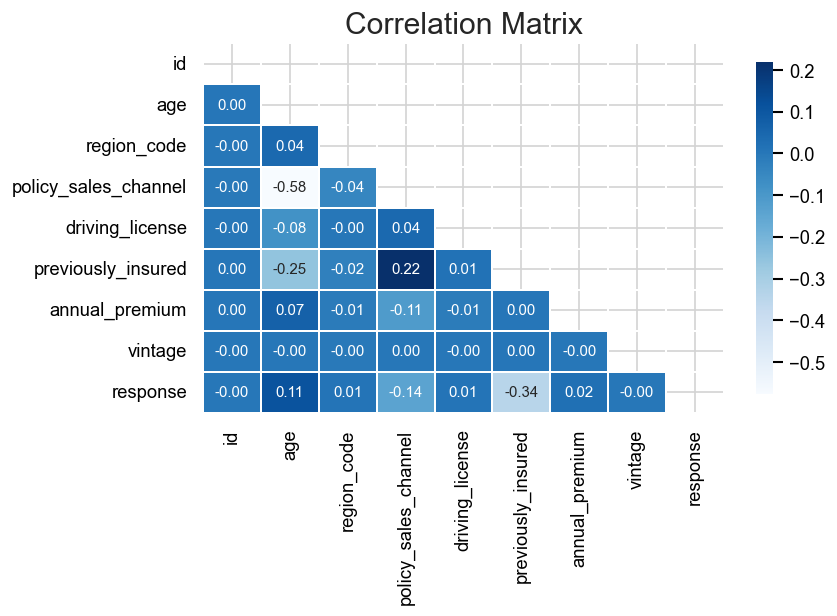

In [85]:
aux = num_attributes.copy()

mask = np.zeros_like(aux.corr(), dtype=bool) 
mask[np.triu_indices_from(mask)] = True 

f, ax = plt.subplots(figsize=(7, 4))

plt.title('Correlation Matrix',fontsize=18)
sns.heatmap(aux.corr(), linewidths=0.25, fmt=".2f", cmap="Blues", linecolor='w', annot=True, annot_kws={"size":9}, mask=mask, cbar_kws={"shrink": .9});

## 5 - DATA PREPARATION

### 5.1 - ML MODELS

In [ ]:
# Parameter "scale_pos_weight" definition

from collections import Counter

# ESTIMATE SCALE_POS_WEIGHT
counter = Counter(y_train)
estimate = counter[0]/counter[1]
print('Estimate: %.3f' % estimate)

#### Logistic Regression

In [ ]:
# Model Definition
clf_lr = LogisticRegression()

In [ ]:
# Pipeline
model_pipeline_lr = pipeline.Pipeline( steps = [("woe_encoder", woe_encoder),
                                                  ("power_transform", power_transform),
                                                  ("clf_lr", clf_lr)])

In [ ]:
cross_validation(5, 'lr', model_pipeline_lr, x_train, y_train, 20000)

In [ ]:
model_pipeline_lr.fit(x_train, y_train)

In [ ]:
yhat_lr_valid = model_pipeline_lr.predict_proba(x_valid)

In [ ]:
fig, axs = plt.subplots(ncols= 3, figsize = (18,5))

# cumulative gain - Metric for sorting problem
skplt.metrics.plot_cumulative_gain(y_valid, yhat_lr_valid, ax=axs[0],title='Cumulative Gain - Logistic Regression');

# Lift Curve
skplt.metrics.plot_lift_curve(y_valid, yhat_lr_valid,ax=axs[1],title='Lift Curve - Logistic Regression');

# Roc Curve
skplt.metrics.plot_roc(y_valid, yhat_lr_valid, ax=axs[2], title='ROC-Curve - Logistic Regression');

plt.tight_layout()

In [ ]:
# Precision and Recall @K
# As per Cumulative Gain chart, it is possible to identify that between 40% and 50% the model is able to find all interested customers.
aux = x_valid['id'].count()
k_value = 20000

precision_lr = precision_at_k_cv(y_valid, yhat_lr_valid, k_value)
recall_lr = recall_at_k_cv(y_valid, yhat_lr_valid, k_value)
LR_performance = ml_performance('LR', precision_lr, recall_lr )
LR_performance

#### XGB

In [ ]:
# Model Definition
clf_xgb = XGBClassifier(scale_pos_weight = estimate)

In [ ]:
# Pipeline
model_pipeline_xgb = pipeline.Pipeline( steps = [("woe_encoder", woe_encoder),
                                                  ("power_transform", power_transform),
                                                  ("clf_xgb", clf_xgb)])

In [ ]:
cross_validation(5, 'xgb', model_pipeline_xgb, x_train, y_train, 20000)

In [ ]:
model_pipeline_xgb.fit(x_train, y_train)

In [ ]:
yhat_xgb = model_pipeline_xgb.predict_proba(x_valid)

In [ ]:
fig, axs = plt.subplots(ncols= 3, figsize = (18,5))

# cumulative gain - Metric for sorting problem
skplt.metrics.plot_cumulative_gain(y_valid, yhat_xgb, ax=axs[0],title='Cumulative Gain - XGB');

# Lift Curve
skplt.metrics.plot_lift_curve(y_valid, yhat_xgb, ax=axs[1],title='Lift Curve - XGB');

# Roc Curve
skplt.metrics.plot_roc(y_valid, yhat_xgb, ax=axs[2], title='ROC-Curve - XGB');

plt.tight_layout()

In [ ]:
# Precision and Recall @K

# As per Cumulative Gain chart, it is possible to identify that between 40% and 50% the model is able to find all interested customers.
aux = x_valid['id'].count()
k_value = 20000


precision_xgb = precision_at_k_cv(y_valid, yhat_xgb, k_value)
recall_xgb = recall_at_k_cv(y_valid, yhat_xgb, k_value)
XGB_performance = ml_performance('XGB', precision_xgb, recall_xgb )
XGB_performance

#### KNN

In [ ]:
# Model Definition
clf_knn = KNeighborsClassifier( n_neighbors = 8 )

In [ ]:
# Pipeline
model_pipeline_knn = pipeline.Pipeline( steps = [ ("woe_encoder", woe_encoder),
                                                  ("power_transform", power_transform),
                                                  ("clf_knn", clf_knn)])

In [ ]:
cross_validation(5, 'knn', model_pipeline_knn, x_train, y_train, 20000)

In [ ]:
model_pipeline_knn.fit(x_train, y_train)

In [ ]:
yhat_knn = model_pipeline_knn.predict_proba(x_valid)

In [ ]:
fig, axs = plt.subplots(ncols= 3, figsize = (18,5))

# cumulative gain - Metric for sorting problem
skplt.metrics.plot_cumulative_gain(y_valid, yhat_knn, ax=axs[0],title='Cumulative Gain - XGB');

# Lift Curve
skplt.metrics.plot_lift_curve(y_valid, yhat_knn, ax=axs[1],title='Lift Curve - XGB');

# Roc Curve
skplt.metrics.plot_roc(y_valid, yhat_knn, ax=axs[2], title='ROC-Curve - XGB');

plt.tight_layout()

In [ ]:
# Precision and Recall @K
k_value = 20000


precision_knn = precision_at_k_cv(y_valid, yhat_knn, k_value)
recall_knn = recall_at_k_cv(y_valid, yhat_knn, k_value)
KNN_performance = ml_performance('KNN', precision_knn, recall_knn )
KNN_performance

## 9 - HYPERPARAMETER FINE TUNING

### 9.1 - XGB Fine Tuning

In [ ]:
# XGB
def objective_xgb(trial):
    """Define the objective function"""
    params = {
        'clf_xgb__max_depth': trial.suggest_int('clf_xgb__max_depth', 5, 20),
        'clf_xgb__eta': trial.suggest_float('clf_xgb__eta', 0.01, 0.05),
        'clf_xgb__learning_rate': trial.suggest_loguniform('clf_xgb__learning_rate', 0.01, 1.0),
        'clf_xgb__n_estimators': trial.suggest_int('clf_xgb__n_estimators', 100, 1000),
        'clf_xgb__min_child_weight': trial.suggest_int('clf_xgb__min_child_weight', 1, 15),
        'clf_xgb__gamma': trial.suggest_loguniform('clf_xgb__gamma', 1e-8, 1.0),
        'clf_xgb__subsample': trial.suggest_loguniform('clf_xgb__subsample', 0.01, 1.0),
        'clf_xgb__colsample_bytree': trial.suggest_loguniform('clf_xgb__colsample_bytree', 0.1, 1.0),
        'clf_xgb__reg_alpha': trial.suggest_loguniform('clf_xgb__reg_alpha', 1e-8, 1.0),
        'clf_xgb__reg_lambda': trial.suggest_loguniform('clf_xgb__reg_lambda', 1e-8, 1.0),
        'clf_xgb__eval_metric': 'mlogloss'
    }

    # Fit the model
    model_pipeline_xgb.set_params(**params)
    model_pipeline_xgb.fit(x_train, y_train)

    # Make predictions
    optuna_xgb_pred = model_pipeline_xgb.predict_proba(x_valid)

    # Evaluate predictions
    aux = x_valid['id'].count()
    k_value = round(0.4 * aux)
    k_value
    recall_atK = recall_at_k_cv(y_valid, optuna_xgb_pred, k_value)
    return  recall_atK

In [ ]:
study_xgb = optuna.create_study(direction='maximize')
study_xgb.optimize(objective_xgb, n_trials=2)

In [ ]:
print('Number of finished trials: {}'.format(len(study_xgb.trials)))
print('Best trial:')
trial = study_xgb.best_trial

print('  Value: {}'.format(trial.value))
print('  Params: ')

for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))

In [ ]:
param_xgb = {'scale_pos_weight': estimate,
             'max_depth': 6,
             'eta': 0.0310260525237683,
             'learning_rate': 0.03914508739999509,
             'n_estimators': 619,
             'min_child_weight': 9,
             'gamma': 3.06408087126589e-05,
             'subsample': 0.3640515535413122,
             'colsample_bytree': 0.449945653612218,
             'reg_alpha': 0.143727642904309,
             'reg_lambda': 0.020464155005749916
            }

## 9.3 - ML Model After Tuning

In [ ]:
x_lasttrain = pd.concat([x_train, x_valid], axis=0)
y_lasttrain = pd.concat([y_train, y_valid], axis=0)

### XGB After Tuning

In [ ]:
# Model Definition
clf_xgb_ft = XGBClassifier(**param_xgb)


In [ ]:
# Pipeline
model_pipeline_xgb_ft = pipeline.Pipeline( steps = [("woe_encoder", woe_encoder),
                                                   ("power_transform", power_transform),
                                                   ("clf_xgb_ft", clf_xgb_ft)])

In [ ]:
model_pipeline_xgb_ft.fit(x_lasttrain, y_lasttrain)

In [ ]:
yhat_xgb_ft = model_pipeline_xgb_ft.predict_proba(x_test)

In [ ]:
fig, axs = plt.subplots(ncols= 3, figsize = (18,5))

# cumulative gain - Metric for sorting problem
skplt.metrics.plot_cumulative_gain(y_test, yhat_xgb_ft, ax=axs[0],title='Cumulative Gain - XGB');

# Lift Curve
skplt.metrics.plot_lift_curve(y_test, yhat_xgb_ft,ax=axs[1],title='Lift Curve - XGB');

# Roc Curve
skplt.metrics.plot_roc(y_test, yhat_xgb_ft, ax=axs[2], title='ROC-Curve - XGB');

plt.tight_layout()

In [ ]:
# Precision and Recall @K
k_value = 20000


precision_xgb_ft = precision_at_k_cv(y_test, yhat_xgb_ft, k_value)
recall_xgb_ft = recall_at_k_cv(y_test, yhat_xgb_ft, k_value)
KNN_performance = ml_performance('XGB FT', precision_xgb_ft, recall_xgb_ft )
KNN_performance

In [ ]:
# Precision and Recall @K
cross_validation(5, 'xgb_tuned', model_pipeline_xgb_ft, x_lasttrain, y_lasttrain, 20000)

## 10 - DEPLOYING MODEL TO PRODUCTION

### 10.1 - HEALTHINSURANCE CLASS

In [ ]:
import pickle
import inflection
import numpy  as np
import pandas as pd

class HealthInsurance:
    
    def __init__( self ):
        self.home_path                                = ''
        self.frequency_encode_policy_sales_scaler     = pickle.load( open( self.home_path + 'src/features/frequency_encode_policy_sales_scaler.pkl', 'rb') )
        self.frequency_encode_region_code_scaler      = pickle.load( open( self.home_path + 'src/features/frequency_encode_region_code_scaler.pkl', 'rb') )
        self.target_encode_gender_scaler              = pickle.load( open( self.home_path + 'src/features/target_encode_gender_scaler.pkl', 'rb') )
        self.target_encode_vintage_month_scaler       = pickle.load( open( self.home_path + 'src/features/target_encode_vintage_month_scaler.pkl', 'rb') )
        self.age_scaler                               = pickle.load( open( self.home_path + 'src/features/age_scaler.pkl', 'rb') )
        self.avg_vehicle_damage_region_code_scaler    = pickle.load( open( self.home_path + 'src/features/age_scaler.pkl', 'rb') )
        self.avg_vintage_age_scaler                   = pickle.load( open( self.home_path + 'src/features/avg_vintage_age_scaler.pkl', 'rb') )
        self.vintage_scaler                           = pickle.load( open( self.home_path + 'src/features/vintage_scaler.pkl', 'rb') )
        self.age_premium_scaler                       = pickle.load( open( self.home_path + 'src/features/age_premium_scaler.pkl', 'rb') )
        self.annual_premium_scaler                    = pickle.load( open( self.home_path + 'src/features/age_premium_scaler.pkl', 'rb') )
        self.avg_day_premium_policy_scaler            = pickle.load( open( self.home_path + 'src/features/avg_day_premium_policy_scaler.pkl', 'rb') )
        self.day_premium_scaler                       = pickle.load( open( self.home_path + 'src/features/day_premium_scaler.pkl', 'rb') )
        self.median_premium_by_region_scaler          = pickle.load( open( self.home_path + 'src/features/median_premium_by_region_scaler.pkl', 'rb') )
        self.region_premium_scaler                    = pickle.load( open( self.home_path + 'src/features/region_premium_scaler.pkl', 'rb') )
    
    def data_cleaning( self, df5 ):
 
        ## rename Columns
        cols_old = ['id', 'Gender', 'Age', 'Driving_License', 'Region_Code', 'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium', 'Policy_Sales_Channel', 'Vintage']

        snakecase = lambda x: inflection.underscore( x )
        cols_new = list( map( snakecase, cols_old ) )
        
        # rename
        df5.columns = cols_new
        
        return( df5 )

    def feature_engineering( self, df5 ):
        
        # Fitting vehicle_age column
        df5['vehicle_age'] = df5['vehicle_age'].apply(lambda x: 1 if (x == '< 1 Year') else 2 if (x == '1-2 Year') else 3)

        # Fitting vehicle_damage column
        df5['vehicle_damage'] = df5['vehicle_damage'].apply(lambda x: 1 if (x == 'Yes') else 0)
        
        # median_premium_by_region
        dict_region_code = df5[['annual_premium', 'region_code']].groupby('region_code').median().to_dict(orient='dict')['annual_premium']
        df5['median_premium_by_region'] = df5['region_code'].map(dict_region_code)

        # moda policy sales chanel por idade
        mode_policy_per_age = df5[['age', 'policy_sales_channel']].groupby('age').agg(pd.Series.mode).to_dict(orient='dict')['policy_sales_channel']
        df5['mode_policy_per_age'] = df5['age'].map(mode_policy_per_age)

        # Media de carros danificados por idade
        avg_carros_danificados_idade = df5[['age', 'vehicle_damage']].groupby('age').mean().to_dict(orient='dict')['vehicle_damage']
        df5['avg_vehicle_damage_per_age'] = df5['age'].map(avg_carros_danificados_idade)

        # Media de carros danificados por regiao
        avg_carros_danificados_regiao = df5[['age', 'region_code']].groupby('age').mean().to_dict(orient='dict')['region_code']
        df5['avg_vehicle_damage_region_code'] = df5['age'].map(avg_carros_danificados_regiao)

        # age_group feature creation
        df5['age_group'] = df5['age'].apply(lambda x: 1 if (x >= 18 | x < 30 ) else 2 if (x >= 30 | x < 60 ) else 3)

        # vintage_month feature cration
        df5['vintage_month'] = round(df5['vintage'] / 31)

        # day_premium feature creation
        df5['day_premium'] = df5['annual_premium']/df5['vintage']

        # age_premium feature cration
        df5['age_premium'] = df5['annual_premium']/df5['age']

        # Calculating Median Annual Premium by Region_code
        premium_rc = df5[['annual_premium', 'region_code']].groupby('region_code').median().to_dict(orient='dict')['annual_premium']
        df5['region_premium'] = df5['region_code'].map(premium_rc)

        # Calculating Median Aday_premium per policy_sales_channel
        day_premium_psc = df5[['day_premium', 'policy_sales_channel']].groupby('policy_sales_channel').mean().to_dict(orient='dict')['day_premium']
        df5['avg_day_premium_policy'] = df5['policy_sales_channel'].map(day_premium_psc)

        # avg vintage per age
        avg_vintage_per_age = df5[['age', 'vintage']].groupby('age').mean().to_dict(orient='dict')['vintage']
        df5['avg_vintage_age'] = df5['age'].map(avg_vintage_per_age)
        
        return( df5 )
    
    def data_preparation( self, df5 ):
              
        # STANDARDIZATION

        # annual premium
        df5['annual_premium'] = self.annual_premium_scaler.transform( df5[['annual_premium']].values )

        # age_premium
        df5['age_premium'] = self.age_premium_scaler.transform( df5[['age_premium']].values )

        # day_premium
        df5['day_premium'] = self.day_premium_scaler.transform( df5[['day_premium']].values )

        # avg_day_premium_policy
        df5['avg_day_premium_policy'] = self.avg_day_premium_policy_scaler.transform( df5[['avg_day_premium_policy']].values )

        # median_premium_by_region
        df5['median_premium_by_region'] = self.median_premium_by_region_scaler.transform( df5[['median_premium_by_region']].values )

        # region_premium
        df5['region_premium'] = self.region_premium_scaler.transform( df5[['region_premium']].values )



        # REESCALING

        # age
        df5['age'] = self.age_scaler.transform( df5[['age']].values )

        # vintage
        df5['vintage'] = self.vintage_scaler.transform( df5[['vintage']].values )

        # avg_vintage_age
        df5['avg_vintage_age'] = self.avg_vintage_age_scaler.transform( df5[['avg_vintage_age']].values )

        # vintage_month
        df5['vintage_month'] = self.vintage_scaler.transform( df5[['vintage_month']].values )

        # avg_vehicle_damage_region_code
        df5['avg_vehicle_damage_region_code'] = self.avg_vehicle_damage_region_code_scaler.transform( df5[['avg_vehicle_damage_region_code']].values )



        # ENCODER

        # policy sales channel
        df5.loc[:, 'policy_sales_channel'] = df5['policy_sales_channel'].map( self.frequency_encode_policy_sales_scaler )

        # region code
        df5.loc[:, 'region_code'] = df5['region_code'].map( self.frequency_encode_region_code_scaler )

        # gender
        df5.loc[:, 'gender'] = df5['gender'].map( self.target_encode_gender_scaler )

        # vintage_month
        df5.loc[:, 'vintage_month'] = df5['vintage_month'].map( self.target_encode_vintage_month_scaler )

        # FILL NAN VALUES
        x_valid = x_valid.fillna(0)
        
        # Feature Selection
        cols_selected = ['vehicle_damage','previously_insured','vintage','day_premium','age_premium','annual_premium','vintage_month','region_code','avg_vehicle_damage_per_age','policy_sales_channel','age','median_premium_by_region','region_premium',
                         'avg_day_premium_policy','vehicle_age','avg_vehicle_damage_region_code','avg_vintage_age','gender']
        
        return df5[cols_selected]
    

    def get_prediction( self, model, original_data, test_data ):
        # prediction
        pred = model.predict_proba( test_data )
        
        # join pred into the original data
        original_data['score'] = pred[:, 1].tolist()
        
        return original_data.to_json( orient='records', date_format='iso' )

### 10.2 - API HANDLER

In [ ]:
import pickle
import pandas as pd
import os
from flask                           import Flask, request, Response
from healthinsurance.healthinsurance import HealthInsurance

# logading model
model = pickle.load( open( 'src/models/xgb_model.pkl', 'rb' ) )
                          
# initialize API
app = Flask( __name__ )

@app.route( '/healthinsurance/predict', methods=['POST'] )
def health_insurance_predict():
    test_json = request.get_json()
    
    if test_json: #there is data
               
        if isinstance( test_json, dict ): # unique example
            test_raw = pd.DataFrame( test_json, index=[0] )
    
        else:
            test_raw = pd.DataFrame( test_json, columns=test_json[0].keys() ) # multiple examples
            
        # Instantiate Rossmann Class
        pipeline = HealthInsurance()

        # data cleaning
        df1 = pipeline.data_cleaning( test_raw )
              
        # feature engineering
        df2 = pipeline.feature_engineering( df1 )

        # Data Preparation
        df3 = pipeline.data_preparation( df2 )
                              
        # prediction
        df_response = pipeline.get_prediction( model, test_raw, df3 )
        
        return df_response
        
    else:
        return Response( '{}', status=200, mimetype='application/json' )

if __name__ == '__main__':
    app.run('0.0.0.0')

#    port = os.environ.get('PORT', 5000)
#    app.run( host='0.0.0.0', port=port )

## 11 - BUSINESS QUESTIONS

In [ ]:
df_11 = pd.concat([x_test, y_test], axis=1)

In [ ]:
df_11['prediction'] = yhat_lgbm_ft[:,1]

In [ ]:
df_11.head()

### 1 - What percentage of customers interested in purchasing a car insurance will the sales team be able to contact by making 20,000 calls?

In [ ]:
n = 20000
ax1 = df_11['id'][(df_11['prediction'] > 0.5)].count()
q1 = df_11.sort_values(by='prediction', ascending=False)
ax2 = q1.iloc[:20000]
ax3 = (ax2['response'] == 1).sum()
ax4 = (df_11['response'] == 1).sum()

print(f'Numbers os contacts: {n} ({n/len(df_11):.2%})')
print(f'Will impact {ax3/ax4:.2%} of interested customers')

### 2 -  And if the sales team's capacity increases to 40,000 calls, what percentage of customers interested in purchasing a car insurance will the sales team be able to contact?

In [ ]:
n = 40000
ax1 = df_11['id'][(df_11['prediction'] > 0.5)].count()
q1 = df_11.sort_values(by='prediction', ascending=False)
ax2 = q1.iloc[:40000]
ax3 = (ax2['response'] == 1).sum()
ax4 = (df_11['response'] == 1).sum()

print(f'Numbers os contacts: {n} ({n/len(df_11):.2%})')
print(f'Will impact {ax3/ax4:.2%} of interested customers')

### 3 - How many calls does the sales team need to make to contact 80% of customers interested in purchasing a car insurance?

In [ ]:
n = 20000
ax1 = df_11['id'][(df_11['prediction'] > 0.5)].count()
q1 = df_11.sort_values(by='prediction', ascending=False)
ax2 = q1.iloc[:23500]
ax3 = (ax2['response'] == 1).sum()
ax4 = (df_11['response'] == 1).sum()

print(f'Numbers os contacts: {n} ({n/len(df_11):.2%})')
print(f'Will impact {ax3/ax4:.2%} of interested customers')